# * Prepaid Performance

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
# from matplotlib.ticker import MaxNLocator
import datetime

mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

## Import Data Source

In [115]:
data_src = "../Raw-Agg Perf Nationwide_Wk 2023022.csv"
df = pd.read_csv(data_src, low_memory=False)
cols = ['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_YR', 'CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'ACTUAL_AS_OF', 'AGG_TYPE', 'RR_IND', 'GRY_IND', 'UOM', 'PERIOD', 'ACTUAL_SNAP', 'ACTUAL_AGG', 'TARGET_SNAP', 'TARGET_AGG', 'PPN_TM']

prepaid_rev_cd_list = ['B1R000100', 'B1R000101', 'B1R000102']
prepaid_dtac_rev_cd_list = ['DB1R000100', 'DB1R000101', 'DB1R000102']
prepaid_tmh_rev_cd_list = ['TB1R000100', 'TB1R000101', 'TB1R000102']
prepaid_all_rev_cd_list = prepaid_rev_cd_list + prepaid_dtac_rev_cd_list + prepaid_tmh_rev_cd_list
prepaid_total_rev_cd_list = ['B1R000100', 'DB1R000100', 'TB1R000100']

# df = df[df['TM_KEY_MTH'] <= 202305] # MONTH filter
# df = df[df['TM_KEY_WK'] <= 2023022] # WEEK filter
df = df[df['TM_KEY_DAY'] <= 20230603] # DAY filter
df = df[df['METRIC_CD'].isin(prepaid_all_rev_cd_list)].reset_index()
df.tail(3)

,index,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,DAY_DESC,MONTH_DESC,QUARTER_DESC,COMP_CD,...,SEQ,PRIORITY,REMARK,AREA_TYPE,AREA_CD,AREA_NAME,REMARK_ACTUAL,REMARK_TARGET,PPN_TM,METRIC_NAME_GROUP
852,34624,20230601,2023022,202306,20232,2023,Thursday,June,Quarter 2,TRUE,...,2002.0,High,NaN,P,P,Nationwide,jutar11,Daily,2023-06-06 13:50:56,Prepaid Revenue
853,34625,20230602,2023022,202306,20232,2023,Friday,June,Quarter 2,TRUE,...,2002.0,High,NaN,P,P,Nationwide,jutar11,Daily,2023-06-06 13:50:56,Prepaid Revenue
854,34626,20230603,2023022,202306,20232,2023,Saturday,June,Quarter 2,TRUE,...,2002.0,High,NaN,P,P,Nationwide,jutar11,Daily,2023-06-06 13:50:56,Prepaid Revenue


In [116]:
df.shape
# df.groupby(['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME']).size().reset_index()

(855, 55)

In [117]:
# ''' Find Metric '''
# # df_metric = df.groupby(['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME']).size().reset_index()
# df_agg_s = df[df['AGG_TYPE']=='S'].groupby(['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE']).agg({'ACTUAL_SNAP': 'sum', 'TARGET_SNAP': 'sum'}).reset_index()
# df_agg_n = df.loc[df[df['AGG_TYPE']=='N'].groupby('METRIC_CD')['TM_KEY_DAY'].idxmax()].reset_index()
# df_agg_n = df_agg_n[['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE', 'ACTUAL_SNAP', 'TARGET_SNAP']]#.reset_index()
# df_metric = pd.concat([df_agg_s, df_agg_n])
# df_metric

# df_tmp = df_metric[df_metric['PRODUCT_GRP']=="Prepaid"]#.reset_index()
# # df_tmp = df_tmp[df_tmp['METRIC_GRP']=="Revenue"]
# # df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Revenue")].reset_index()
# # df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Sub")]#.reset_index()

# # df_tmp.to_excel('Prepaid_Metric.xlsx')
# df_tmp

## Data Preporation

In [118]:
''' Function : Unit Million Baht '''
def unit_mb(baht):
    n = baht
    unit_mb = n / 1000000
    return unit_mb

''' Modify '''
df.loc[:, 'ACTUAL_SNAP'] = unit_mb(df['ACTUAL_SNAP'])
df.loc[:, 'ACTUAL_AGG'] = unit_mb(df['ACTUAL_AGG'])
df.loc[:, 'TARGET_SNAP'] = unit_mb(df['TARGET_SNAP'])
df.loc[:, 'TARGET_AGG'] = unit_mb(df['TARGET_AGG'])
df['MTH_DESC'] = pd.to_datetime(df['TM_KEY_MTH'], format='%Y%m', errors='coerce').dt.strftime('%B')

''' Datetime values '''
curr_yr = max(df['TM_KEY_YR'])
last_yr = max(df['TM_KEY_YR'])-1
curr_mth = max(df['TM_KEY_MTH'])
curr_mth_desc = pd.to_datetime(curr_mth, format='%Y%m', errors='coerce').strftime('%B')
last_mth = int(f'{str(last_yr)}01') if str(curr_mth)[4:]=='01' else curr_mth-1
curr_wk = max(df['TM_KEY_WK'])
curr_day = max(df['TM_KEY_DAY'])
last_ppn_tm = max(df['PPN_TM'])

# df.tail(3)

In [119]:
''' Pivot Rawdata '''
# df_tmp = df.loc[:, ['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'METRIC_CD', 'METRIC_NAME', 'ACTUAL_SNAP', 'ACTUAL_AGG', 'TARGET_SNAP', 'TARGET_AGG', 'MTH_DESC']]#.reset_index()

''' Pivot Actual by KPIS '''
df_rev_act_pivot = df.pivot(index=['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'MTH_DESC'], columns=['METRIC_NAME'], values='ACTUAL_SNAP').reset_index()
df_rev_act_pivot.rename(columns=({'Prepaid Existing Revenue': 'ACTUAL_EXIST', 'Prepaid Existing Revenue : DTAC': 'ACTUAL_EXIST_DTAC', 'Prepaid Existing Revenue : TMH': 'ACTUAL_EXIST_TMH',
                                  'Prepaid New Revenue': 'ACTUAL_NEW', 'Prepaid New Revenue : DTAC': 'ACTUAL_NEW_DTAC', 'Prepaid New Revenue : TMH': 'ACTUAL_NEW_TMH',
                                  'Prepaid Revenue': 'ACTUAL', 'Prepaid Revenue : DTAC': 'ACTUAL_DTAC', 'Prepaid Revenue : TMH': 'ACTUAL_TMH'}), inplace=True)

''' Pivot Target by KPIS '''
df_rev_tgt_pivot = df.pivot(index='TM_KEY_DAY', columns='METRIC_NAME', values='TARGET_SNAP').reset_index()
df_rev_tgt_pivot.rename(columns=({'Prepaid Existing Revenue': 'TARGET_EXIST', 'Prepaid Existing Revenue : DTAC': 'TARGET_EXIST_DTAC', 'Prepaid Existing Revenue : TMH': 'TARGET_EXIST_TMH',
                                  'Prepaid New Revenue': 'TARGET_NEW', 'Prepaid New Revenue : DTAC': 'TARGET_NEW_DTAC', 'Prepaid New Revenue : TMH': 'TARGET_NEW_TMH',
                                  'Prepaid Revenue': 'TARGET', 'Prepaid Revenue : DTAC': 'TARGET_DTAC', 'Prepaid Revenue : TMH': 'TARGET_TMH'}), inplace=True)

''' Aggregation '''
df_rev_pivot_agg = pd.merge(df_rev_act_pivot, df_rev_tgt_pivot, on='TM_KEY_DAY')
df_rev_pivot_agg['WK_LABEL'] = df_rev_pivot_agg['TM_KEY_WK'].apply(str).str[5:].astype(int)
df_rev_pivot_agg['DAY_LABEL'] = df_rev_pivot_agg['TM_KEY_DAY'].apply(str).str[6:].astype(int)

df_rev_pivot_agg.tail(3)

METRIC_NAME,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,MTH_DESC,ACTUAL_EXIST,ACTUAL_EXIST_DTAC,ACTUAL_EXIST_TMH,ACTUAL_NEW,...,TARGET_EXIST_DTAC,TARGET_EXIST_TMH,TARGET_NEW,TARGET_NEW_DTAC,TARGET_NEW_TMH,TARGET,TARGET_DTAC,TARGET_TMH,WK_LABEL,DAY_LABEL
92,20230601,2023022,202306,20232,2023,June,109.802532,43.563280,66.239253,36.178010,...,NaN,53.251122,NaN,NaN,15.510926,129.880082,61.118034,68.762048,22,1
93,20230602,2023022,202306,20232,2023,June,101.391567,41.015741,60.375826,37.327119,...,NaN,53.251122,NaN,NaN,15.510926,127.078845,58.316796,68.762048,22,2
94,20230603,2023022,202306,20232,2023,June,99.975382,38.088554,61.886827,29.293687,...,NaN,53.251122,NaN,NaN,15.510926,124.539946,55.777897,68.762048,22,3


## ** Yearly

### YR : Aggregation

In [120]:
''' Aggregate by year '''
df_rev_yr = df_rev_pivot_agg.groupby('TM_KEY_YR')\
    .sum(numeric_only=True)[['ACTUAL', 'ACTUAL_DTAC', 'ACTUAL_TMH', 'TARGET', 'TARGET_DTAC', 'TARGET_TMH', 
                             'ACTUAL_NEW', 'ACTUAL_NEW_DTAC', 'ACTUAL_NEW_TMH', 'TARGET_NEW', 'TARGET_NEW_DTAC', 'TARGET_NEW_TMH', 
                             'ACTUAL_EXIST', 'ACTUAL_EXIST_DTAC', 'ACTUAL_EXIST_TMH', 'TARGET_EXIST', 'TARGET_EXIST_DTAC', 'TARGET_EXIST_TMH']].reset_index()

''' Aggregation '''
df_rev_yr['%ACHV'] = (df_rev_yr['ACTUAL'] / df_rev_yr['TARGET'])
df_rev_yr['%ACHV_DTAC'] = (df_rev_yr['ACTUAL_DTAC'] / df_rev_yr['TARGET_DTAC'])
df_rev_yr['%ACHV_TMH'] = (df_rev_yr['ACTUAL_TMH'] / df_rev_yr['TARGET_TMH'])
df_rev_yr['GAP'] = df_rev_yr['ACTUAL'] - df_rev_yr['TARGET']
df_rev_yr['GAP_DTAC'] = df_rev_yr['ACTUAL_DTAC'] - df_rev_yr['TARGET_DTAC']
df_rev_yr['GAP_TMH'] = df_rev_yr['ACTUAL_TMH'] - df_rev_yr['TARGET_TMH']
df_rev_yr['DIFF'] = df_rev_yr['ACTUAL'].diff()
df_rev_yr['DIFF_DTAC'] = df_rev_yr['ACTUAL_DTAC'].diff()
df_rev_yr['DIFF_TMH'] = df_rev_yr['ACTUAL_TMH'].diff()
df_rev_yr['LAST_ACT'] = df_rev_yr['ACTUAL'] - df_rev_yr['DIFF']
df_rev_yr['LAST_ACT_DTAC'] = df_rev_yr['ACTUAL_DTAC'] - df_rev_yr['DIFF_DTAC']
df_rev_yr['LAST_ACT_TMH'] = df_rev_yr['ACTUAL_TMH'] - df_rev_yr['DIFF_TMH']
df_rev_yr['%YOY'] = (df_rev_yr['ACTUAL'] / df_rev_yr['LAST_ACT']) - 1
df_rev_yr['%YOY_DTAC'] = (df_rev_yr['ACTUAL_DTAC'] / df_rev_yr['LAST_ACT_DTAC']) - 1
df_rev_yr['%YOY_TMH'] = (df_rev_yr['ACTUAL_TMH'] / df_rev_yr['LAST_ACT_TMH']) - 1

''' NEW : Aggregation '''
df_rev_yr['%ACHV_NEW'] = (df_rev_yr['ACTUAL_NEW'] / df_rev_yr['TARGET_NEW'])
df_rev_yr['%ACHV_NEW_DTAC'] = (df_rev_yr['ACTUAL_NEW_DTAC'] / df_rev_yr['TARGET_NEW_DTAC'])
df_rev_yr['%ACHV_NEW_TMH'] = (df_rev_yr['ACTUAL_NEW_TMH'] / df_rev_yr['TARGET_NEW_TMH'])
df_rev_yr['GAP_NEW'] = df_rev_yr['ACTUAL_NEW'] - df_rev_yr['TARGET_NEW']
df_rev_yr['GAP_NEW_DTAC'] = df_rev_yr['ACTUAL_NEW_DTAC'] - df_rev_yr['TARGET_NEW_DTAC']
df_rev_yr['GAP_NEW_TMH'] = df_rev_yr['ACTUAL_NEW_TMH'] - df_rev_yr['TARGET_NEW_TMH']
df_rev_yr['DIFF_NEW'] = df_rev_yr['ACTUAL_NEW'].diff()
df_rev_yr['DIFF_NEW_DTAC'] = df_rev_yr['ACTUAL_NEW_DTAC'].diff()
df_rev_yr['DIFF_NEW_TMH'] = df_rev_yr['ACTUAL_NEW_TMH'].diff()
df_rev_yr['LAST_ACT_NEW'] = df_rev_yr['ACTUAL_NEW'] - df_rev_yr['DIFF_NEW']
df_rev_yr['LAST_ACT_NEW_DTAC'] = df_rev_yr['ACTUAL_NEW_DTAC'] - df_rev_yr['DIFF_NEW_DTAC']
df_rev_yr['LAST_ACT_NEW_TMH'] = df_rev_yr['ACTUAL_NEW_TMH'] - df_rev_yr['DIFF_NEW_TMH']
df_rev_yr['%YOY_NEW'] = (df_rev_yr['ACTUAL_NEW'] / df_rev_yr['LAST_ACT_NEW']) - 1
df_rev_yr['%YOY_NEW_DTAC'] = (df_rev_yr['ACTUAL_NEW_DTAC'] / df_rev_yr['LAST_ACT_NEW_DTAC']) - 1
df_rev_yr['%YOY_NEW_TMH'] = (df_rev_yr['ACTUAL_NEW_TMH'] / df_rev_yr['LAST_ACT_NEW_TMH']) - 1

''' EXIST : Aggregation '''
df_rev_yr['%ACHV_EXIST'] = (df_rev_yr['ACTUAL_EXIST'] / df_rev_yr['TARGET_EXIST'])
df_rev_yr['%ACHV_EXIST_DTAC'] = (df_rev_yr['ACTUAL_EXIST_DTAC'] / df_rev_yr['TARGET_EXIST_DTAC'])
df_rev_yr['%ACHV_EXIST_TMH'] = (df_rev_yr['ACTUAL_EXIST_TMH'] / df_rev_yr['TARGET_EXIST_TMH'])
df_rev_yr['GAP_EXIST'] = df_rev_yr['ACTUAL_EXIST'] - df_rev_yr['TARGET_EXIST']
df_rev_yr['GAP_EXIST_DTAC'] = df_rev_yr['ACTUAL_EXIST_DTAC'] - df_rev_yr['TARGET_EXIST_DTAC']
df_rev_yr['GAP_EXIST_TMH'] = df_rev_yr['ACTUAL_EXIST_TMH'] - df_rev_yr['TARGET_EXIST_TMH']
df_rev_yr['DIFF_EXIST'] = df_rev_yr['ACTUAL_EXIST'].diff()
df_rev_yr['DIFF_EXIST_DTAC'] = df_rev_yr['ACTUAL_EXIST_DTAC'].diff()
df_rev_yr['DIFF_EXIST_TMH'] = df_rev_yr['ACTUAL_EXIST_TMH'].diff()
df_rev_yr['LAST_ACT_EXIST'] = df_rev_yr['ACTUAL_EXIST'] - df_rev_yr['DIFF_EXIST']
df_rev_yr['LAST_ACT_EXIST_DTAC'] = df_rev_yr['ACTUAL_EXIST_DTAC'] - df_rev_yr['DIFF_EXIST_DTAC']
df_rev_yr['LAST_ACT_EXIST_TMH'] = df_rev_yr['ACTUAL_EXIST_TMH'] - df_rev_yr['DIFF_EXIST_TMH']
df_rev_yr['%YOY_EXIST'] = (df_rev_yr['ACTUAL_EXIST'] / df_rev_yr['LAST_ACT_EXIST']) - 1
df_rev_yr['%YOY_EXIST_DTAC'] = (df_rev_yr['ACTUAL_EXIST_DTAC'] / df_rev_yr['LAST_ACT_EXIST_DTAC']) - 1
df_rev_yr['%YOY_EXIST_TMH'] = (df_rev_yr['ACTUAL_EXIST_TMH'] / df_rev_yr['LAST_ACT_EXIST_TMH']) - 1

df_rev_yr
# df_rev_yr.to_excel("temp.xlsx")

METRIC_NAME,TM_KEY_YR,ACTUAL,ACTUAL_DTAC,ACTUAL_TMH,TARGET,TARGET_DTAC,TARGET_TMH,ACTUAL_NEW,ACTUAL_NEW_DTAC,ACTUAL_NEW_TMH,...,GAP_EXIST_TMH,DIFF_EXIST,DIFF_EXIST_DTAC,DIFF_EXIST_TMH,LAST_ACT_EXIST,LAST_ACT_EXIST_DTAC,LAST_ACT_EXIST_TMH,%YOY_EXIST,%YOY_EXIST_DTAC,%YOY_EXIST_TMH
0,2023,11415.9452,4978.976205,6436.968995,11404.291507,5050.488919,6353.802587,2540.208589,1337.306919,1202.90167,...,60.605587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [121]:
''' Year Chart Values '''
x = df_rev_yr['TM_KEY_YR']
x_axis = np.arange(len(x))

''' Values '''
y_act = df_rev_yr['ACTUAL'].round(2)
y_act_dtac = df_rev_yr['ACTUAL_DTAC'].round(2)
y_act_tmh = df_rev_yr['ACTUAL_TMH'].round(2)
y_tgt = df_rev_yr['TARGET'].round(2)
y_tgt_dtac = df_rev_yr['TARGET_DTAC'].round(2)
y_tgt_tmh = df_rev_yr['TARGET_TMH'].round(2)
y_achv = df_rev_yr['%ACHV']
y_achv_dtac = df_rev_yr['%ACHV_DTAC']
y_achv_tmh = df_rev_yr['%ACHV_TMH']
y_gap = df_rev_yr['GAP'].round(2)
y_gap_dtac = df_rev_yr['GAP_DTAC'].round(2)
y_gap_tmh = df_rev_yr['GAP_TMH'].round(2)
y_diff = df_rev_yr['DIFF'].round(2)
y_diff_dtac = df_rev_yr['DIFF_DTAC'].round(2)
y_diff_tmh = df_rev_yr['DIFF_TMH'].round(2)
y_last_act = df_rev_yr['LAST_ACT'].round(2)
y_last_act_dtac = df_rev_yr['LAST_ACT_DTAC'].round(2)
y_last_act_tmh = df_rev_yr['LAST_ACT_TMH'].round(2)
y_yoy = df_rev_yr['%YOY']
y_yoy_dtac = df_rev_yr['%YOY_DTAC']
y_yoy_tmh = df_rev_yr['%YOY_TMH']

''' NEW : Values '''
y_act_new = df_rev_yr['ACTUAL_NEW'].round(2)
y_act_new_dtac = df_rev_yr['ACTUAL_NEW_DTAC'].round(2)
y_act_new_tmh = df_rev_yr['ACTUAL_NEW_TMH'].round(2)
y_tgt_new = df_rev_yr['TARGET_NEW'].round(2)
y_tgt_new_dtac = df_rev_yr['TARGET_NEW_DTAC'].round(2)
y_tgt_new_tmh = df_rev_yr['TARGET_NEW_TMH'].round(2)
y_achv_new = df_rev_yr['%ACHV_NEW']
y_achv_new_dtac = df_rev_yr['%ACHV_NEW_DTAC']
y_achv_new_tmh = df_rev_yr['%ACHV_NEW_TMH']
y_gap_new = df_rev_yr['GAP_NEW'].round(2)
y_gap_new_dtac = df_rev_yr['GAP_NEW_DTAC'].round(2)
y_gap_new_tmh = df_rev_yr['GAP_NEW_TMH'].round(2)
y_diff_new = df_rev_yr['DIFF_NEW'].round(2)
y_diff_new_dtac = df_rev_yr['DIFF_NEW_DTAC'].round(2)
y_diff_new_tmh = df_rev_yr['DIFF_NEW_TMH'].round(2)
y_last_act_new = df_rev_yr['LAST_ACT_NEW'].round(2)
y_last_act_new_dtac = df_rev_yr['LAST_ACT_NEW_DTAC'].round(2)
y_last_act_new_tmh = df_rev_yr['LAST_ACT_NEW_TMH'].round(2)
y_yoy_new = df_rev_yr['%YOY_NEW']
y_yoy_new_dtac = df_rev_yr['%YOY_NEW_DTAC']
y_yoy_new_tmh = df_rev_yr['%YOY_NEW_TMH']

''' EXIST : Values '''
y_act_exist = df_rev_yr['ACTUAL_EXIST'].round(2)
y_act_exist_dtac = df_rev_yr['ACTUAL_EXIST_DTAC'].round(2)
y_act_exist_tmh = df_rev_yr['ACTUAL_EXIST_TMH'].round(2)
y_tgt_exist = df_rev_yr['TARGET_EXIST'].round(2)
y_tgt_exist_dtac = df_rev_yr['TARGET_EXIST_DTAC'].round(2)
y_tgt_exist_tmh = df_rev_yr['TARGET_EXIST_TMH'].round(2)
y_achv_exist = df_rev_yr['%ACHV_EXIST']
y_achv_exist_dtac = df_rev_yr['%ACHV_EXIST_DTAC']
y_achv_exist_tmh = df_rev_yr['%ACHV_EXIST_TMH']
y_gap_exist = df_rev_yr['GAP_EXIST'].round(2)
y_gap_exist_dtac = df_rev_yr['GAP_EXIST_DTAC'].round(2)
y_gap_exist_tmh = df_rev_yr['GAP_EXIST_TMH'].round(2)
y_diff_exist = df_rev_yr['DIFF_EXIST'].round(2)
y_diff_exist_dtac = df_rev_yr['DIFF_EXIST_DTAC'].round(2)
y_diff_exist_tmh = df_rev_yr['DIFF_EXIST_TMH'].round(2)
y_last_act_exist = df_rev_yr['LAST_ACT_EXIST'].round(2)
y_last_act_exist_dtac = df_rev_yr['LAST_ACT_EXIST_DTAC'].round(2)
y_last_act_exist_tmh = df_rev_yr['LAST_ACT_EXIST_TMH'].round(2)
y_yoy_exist = df_rev_yr['%YOY_EXIST']
y_yoy_exist_dtac = df_rev_yr['%YOY_EXIST_DTAC']
y_yoy_exist_tmh = df_rev_yr['%YOY_EXIST_TMH']

### YR : Prepaid Revenue Summary

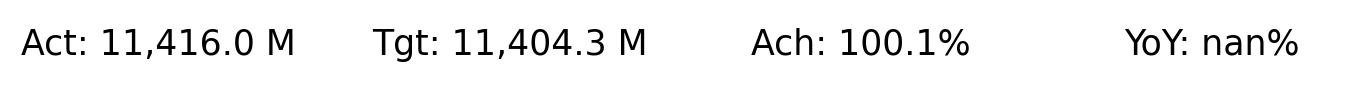

In [122]:
''' Yearly Summary '''
fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(y_act.iloc[-1],',.1f')} M", size=25, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(y_tgt.iloc[-1],',.1f')} M", size=25, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(y_achv.iloc[-1],',.1%')}", size=25, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"YoY: {format(y_yoy.iloc[-1],',.1%')}", size=25, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

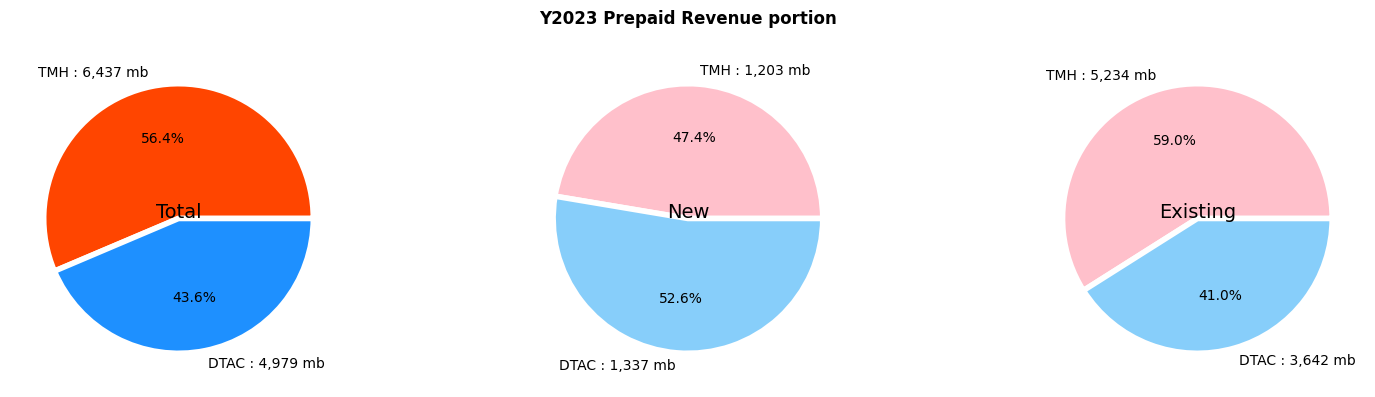

In [123]:
''' Revenue Portion Chart '''

fig = plt.figure(figsize=(16, 4))
fig.suptitle(f'Y{curr_yr} Prepaid Revenue portion', weight='bold')
gs = GridSpec(1, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])

''' ax1 '''
y = np.array([sum(y_act_tmh), sum(y_act_dtac)])
mylabels = [f"TMH : {format(y[0],',.0f')} mb", f"DTAC : {format(y[1],',.0f')} mb"]
mycolors = ["orangered", "dodgerblue"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})#, hatch='/'
ax1.text(0, 0, 'Total', ha='center', fontsize=14)#, weight='bold'

''' ax2 '''
y = np.array([sum(y_act_new_tmh), sum(y_act_new_dtac)])
mylabels = [f"TMH : {format(y[0],',.0f')} mb", f"DTAC : {format(y[1],',.0f')} mb"]
mycolors = ["pink", "lightskyblue"]
ax2.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax2.text(0, 0, 'New', ha='center', fontsize=14)

''' ax3 '''
y = np.array([sum(y_act_exist_tmh), sum(y_act_exist_dtac)])
mylabels = [f"TMH : {format(y[0],',.0f')} mb", f"DTAC : {format(y[1],',.0f')} mb"]
mycolors = ["pink", "lightskyblue"]
ax3.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax3.text(0, 0, 'Existing', ha='center', fontsize=14)

fig.tight_layout()
plt.show()

## ** Monthly

### MTH : Aggregation

In [124]:
''' Month to Date Values '''

last_act_day = df_rev_pivot_agg[(df_rev_pivot_agg['TM_KEY_MTH']==curr_mth) & (df_rev_pivot_agg['ACTUAL']>0)][['DAY_LABEL']]['DAY_LABEL'].max()
last_mtd_act = sum(df_rev_pivot_agg[(df_rev_pivot_agg['TM_KEY_MTH']==last_mth) & (df_rev_pivot_agg['DAY_LABEL']<=last_act_day)][['ACTUAL']].sum())
mtd_act = df_rev_pivot_agg[df_rev_pivot_agg['TM_KEY_MTH']==curr_mth].sum()['ACTUAL']
mtd_tgt = df_rev_pivot_agg[df_rev_pivot_agg['TM_KEY_MTH']==curr_mth].sum()['TARGET']
mtd_achv = mtd_act / mtd_tgt
mtd_mom = (mtd_act / last_mtd_act) - 1
mtd_act_gap = mtd_act - last_mtd_act


In [125]:
''' Aggregate by month '''
df_rev_pivot_agg_curr_yr = df_rev_pivot_agg[df_rev_pivot_agg['TM_KEY_YR']==curr_yr]
df_rev_mth = df_rev_pivot_agg_curr_yr.groupby(['TM_KEY_MTH', 'MTH_DESC'])\
    .sum(numeric_only=True)[['ACTUAL', 'ACTUAL_DTAC', 'ACTUAL_TMH', 'TARGET', 'TARGET_DTAC', 'TARGET_TMH', 
                             'ACTUAL_NEW', 'ACTUAL_NEW_DTAC', 'ACTUAL_NEW_TMH', 'TARGET_NEW', 'TARGET_NEW_DTAC', 'TARGET_NEW_TMH', 
                             'ACTUAL_EXIST', 'ACTUAL_EXIST_DTAC', 'ACTUAL_EXIST_TMH', 'TARGET_EXIST', 'TARGET_EXIST_DTAC', 'TARGET_EXIST_TMH']].reset_index()

''' Aggregation '''
df_rev_mth['%ACHV'] = (df_rev_mth['ACTUAL'] / df_rev_mth['TARGET'])
df_rev_mth['%ACHV_DTAC'] = (df_rev_mth['ACTUAL_DTAC'] / df_rev_mth['TARGET_DTAC'])
df_rev_mth['%ACHV_TMH'] = (df_rev_mth['ACTUAL_TMH'] / df_rev_mth['TARGET_TMH'])
df_rev_mth['GAP'] = df_rev_mth['ACTUAL'] - df_rev_mth['TARGET']
df_rev_mth['GAP_DTAC'] = df_rev_mth['ACTUAL_DTAC'] - df_rev_mth['TARGET_DTAC']
df_rev_mth['GAP_TMH'] = df_rev_mth['ACTUAL_TMH'] - df_rev_mth['TARGET_TMH']
df_rev_mth['DIFF'] = df_rev_mth['ACTUAL'].diff()
df_rev_mth['DIFF_DTAC'] = df_rev_mth['ACTUAL_DTAC'].diff()
df_rev_mth['DIFF_TMH'] = df_rev_mth['ACTUAL_TMH'].diff()
df_rev_mth['LAST_ACT'] = df_rev_mth['ACTUAL'] - df_rev_mth['DIFF']
df_rev_mth['LAST_ACT_DTAC'] = df_rev_mth['ACTUAL_DTAC'] - df_rev_mth['DIFF_DTAC']
df_rev_mth['LAST_ACT_TMH'] = df_rev_mth['ACTUAL_TMH'] - df_rev_mth['DIFF_TMH']
df_rev_mth['%MOM'] = (df_rev_mth['ACTUAL'] / df_rev_mth['LAST_ACT']) - 1
df_rev_mth['%MOM_DTAC'] = (df_rev_mth['ACTUAL_DTAC'] / df_rev_mth['LAST_ACT_DTAC']) - 1
df_rev_mth['%MOM_TMH'] = (df_rev_mth['ACTUAL_TMH'] / df_rev_mth['LAST_ACT_TMH']) - 1

''' NEW : Aggregation '''
df_rev_mth['%ACHV_NEW'] = (df_rev_mth['ACTUAL_NEW'] / df_rev_mth['TARGET_NEW'])
df_rev_mth['%ACHV_NEW_DTAC'] = (df_rev_mth['ACTUAL_NEW_DTAC'] / df_rev_mth['TARGET_NEW_DTAC'])
df_rev_mth['%ACHV_NEW_TMH'] = (df_rev_mth['ACTUAL_NEW_TMH'] / df_rev_mth['TARGET_NEW_TMH'])
df_rev_mth['GAP_NEW'] = df_rev_mth['ACTUAL_NEW'] - df_rev_mth['TARGET_NEW']
df_rev_mth['GAP_NEW_DTAC'] = df_rev_mth['ACTUAL_NEW_DTAC'] - df_rev_mth['TARGET_NEW_DTAC']
df_rev_mth['GAP_NEW_TMH'] = df_rev_mth['ACTUAL_NEW_TMH'] - df_rev_mth['TARGET_NEW_TMH']
df_rev_mth['DIFF_NEW'] = df_rev_mth['ACTUAL_NEW'].diff()
df_rev_mth['DIFF_NEW_DTAC'] = df_rev_mth['ACTUAL_NEW_DTAC'].diff()
df_rev_mth['DIFF_NEW_TMH'] = df_rev_mth['ACTUAL_NEW_TMH'].diff()
df_rev_mth['LAST_ACT_NEW'] = df_rev_mth['ACTUAL_NEW'] - df_rev_mth['DIFF_NEW']
df_rev_mth['LAST_ACT_NEW_DTAC'] = df_rev_mth['ACTUAL_NEW_DTAC'] - df_rev_mth['DIFF_NEW_DTAC']
df_rev_mth['LAST_ACT_NEW_TMH'] = df_rev_mth['ACTUAL_NEW_TMH'] - df_rev_mth['DIFF_NEW_TMH']
df_rev_mth['%MOM_NEW'] = (df_rev_mth['ACTUAL_NEW'] / df_rev_mth['LAST_ACT_NEW']) - 1
df_rev_mth['%MOM_NEW_DTAC'] = (df_rev_mth['ACTUAL_NEW_DTAC'] / df_rev_mth['LAST_ACT_NEW_DTAC']) - 1
df_rev_mth['%MOM_NEW_TMH'] = (df_rev_mth['ACTUAL_NEW_TMH'] / df_rev_mth['LAST_ACT_NEW_TMH']) - 1

''' EXIST : Aggregation '''
df_rev_mth['%ACHV_EXIST'] = (df_rev_mth['ACTUAL_EXIST'] / df_rev_mth['TARGET_EXIST'])
df_rev_mth['%ACHV_EXIST_DTAC'] = (df_rev_mth['ACTUAL_EXIST_DTAC'] / df_rev_mth['TARGET_EXIST_DTAC'])
df_rev_mth['%ACHV_EXIST_TMH'] = (df_rev_mth['ACTUAL_EXIST_TMH'] / df_rev_mth['TARGET_EXIST_TMH'])
df_rev_mth['GAP_EXIST'] = df_rev_mth['ACTUAL_EXIST'] - df_rev_mth['TARGET_EXIST']
df_rev_mth['GAP_EXIST_DTAC'] = df_rev_mth['ACTUAL_EXIST_DTAC'] - df_rev_mth['TARGET_EXIST_DTAC']
df_rev_mth['GAP_EXIST_TMH'] = df_rev_mth['ACTUAL_EXIST_TMH'] - df_rev_mth['TARGET_EXIST_TMH']
df_rev_mth['DIFF_EXIST'] = df_rev_mth['ACTUAL_EXIST'].diff()
df_rev_mth['DIFF_EXIST_DTAC'] = df_rev_mth['ACTUAL_EXIST_DTAC'].diff()
df_rev_mth['DIFF_EXIST_TMH'] = df_rev_mth['ACTUAL_EXIST_TMH'].diff()
df_rev_mth['LAST_ACT_EXIST'] = df_rev_mth['ACTUAL_EXIST'] - df_rev_mth['DIFF_EXIST']
df_rev_mth['LAST_ACT_EXIST_DTAC'] = df_rev_mth['ACTUAL_EXIST_DTAC'] - df_rev_mth['DIFF_EXIST_DTAC']
df_rev_mth['LAST_ACT_EXIST_TMH'] = df_rev_mth['ACTUAL_EXIST_TMH'] - df_rev_mth['DIFF_EXIST_TMH']
df_rev_mth['%MOM_EXIST'] = (df_rev_mth['ACTUAL_EXIST'] / df_rev_mth['LAST_ACT_EXIST']) - 1
df_rev_mth['%MOM_EXIST_DTAC'] = (df_rev_mth['ACTUAL_EXIST_DTAC'] / df_rev_mth['LAST_ACT_EXIST_DTAC']) - 1
df_rev_mth['%MOM_EXIST_TMH'] = (df_rev_mth['ACTUAL_EXIST_TMH'] / df_rev_mth['LAST_ACT_EXIST_TMH']) - 1

df_rev_mth
# df_rev_mth.to_excel("temp.xlsx")

METRIC_NAME,TM_KEY_MTH,MTH_DESC,ACTUAL,ACTUAL_DTAC,ACTUAL_TMH,TARGET,TARGET_DTAC,TARGET_TMH,ACTUAL_NEW,ACTUAL_NEW_DTAC,...,GAP_EXIST_TMH,DIFF_EXIST,DIFF_EXIST_DTAC,DIFF_EXIST_TMH,LAST_ACT_EXIST,LAST_ACT_EXIST_DTAC,LAST_ACT_EXIST_TMH,%MOM_EXIST,%MOM_EXIST_DTAC,%MOM_EXIST_TMH
0,202303,March,3683.557615,1620.241312,2063.316303,3697.837414,1655.402410,2042.435004,705.278407,378.875050,...,27.253383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,202304,April,3584.677321,1569.575558,2015.101763,3639.376740,1590.276264,2049.100476,803.783720,424.846311,...,-21.480938,-197.385607,-96.637014,-100.748592,2978.279208,1241.366262,1736.912946,-0.066275,-0.077847,-0.058004
2,202305,May,3733.741967,1610.280929,2123.461039,3685.578480,1629.597517,2055.980963,928.347647,477.374727,...,26.084603,24.500719,-11.823046,36.323765,2780.893601,1144.729248,1636.164354,0.008810,-0.010328,0.022201
3,202306,June,413.968297,178.878407,235.089890,381.498873,175.212728,206.286145,102.798816,56.210832,...,28.748539,-2494.224839,-1010.238627,-1483.986213,2805.394320,1132.906202,1672.488119,-0.889082,-0.891723,-0.887293


In [126]:
''' Month Chart Values '''
x = df_rev_mth['MTH_DESC']
x_axis = np.arange(len(x))

''' Values '''
y_act = df_rev_mth['ACTUAL'].round(2)
y_act_dtac = df_rev_mth['ACTUAL_DTAC'].round(2)
y_act_tmh = df_rev_mth['ACTUAL_TMH'].round(2)
y_tgt = df_rev_mth['TARGET'].round(2)
y_tgt_dtac = df_rev_mth['TARGET_DTAC'].round(2)
y_tgt_tmh = df_rev_mth['TARGET_TMH'].round(2)
y_achv = df_rev_mth['%ACHV']
y_achv_dtac = df_rev_mth['%ACHV_DTAC']
y_achv_tmh = df_rev_mth['%ACHV_TMH']
y_gap = df_rev_mth['GAP'].round(2)
y_gap_dtac = df_rev_mth['GAP_DTAC'].round(2)
y_gap_tmh = df_rev_mth['GAP_TMH'].round(2)
y_diff = df_rev_mth['DIFF'].round(2)
y_diff_dtac = df_rev_mth['DIFF_DTAC'].round(2)
y_diff_tmh = df_rev_mth['DIFF_TMH'].round(2)
y_last_act = df_rev_mth['LAST_ACT'].round(2)
y_last_act_dtac = df_rev_mth['LAST_ACT_DTAC'].round(2)
y_last_act_tmh = df_rev_mth['LAST_ACT_TMH'].round(2)
y_mom = df_rev_mth['%MOM']
y_mom_dtac = df_rev_mth['%MOM_DTAC']
y_mom_tmh = df_rev_mth['%MOM_TMH']

''' NEW : Values '''
y_act_new = df_rev_mth['ACTUAL_NEW'].round(2)
y_act_new_dtac = df_rev_mth['ACTUAL_NEW_DTAC'].round(2)
y_act_new_tmh = df_rev_mth['ACTUAL_NEW_TMH'].round(2)
y_tgt_new = df_rev_mth['TARGET_NEW'].round(2)
y_tgt_new_dtac = df_rev_mth['TARGET_NEW_DTAC'].round(2)
y_tgt_new_tmh = df_rev_mth['TARGET_NEW_TMH'].round(2)
y_achv_new = df_rev_mth['%ACHV_NEW']
y_achv_new_dtac = df_rev_mth['%ACHV_NEW_DTAC']
y_achv_new_tmh = df_rev_mth['%ACHV_NEW_TMH']
y_gap_new = df_rev_mth['GAP_NEW'].round(2)
y_gap_new_dtac = df_rev_mth['GAP_NEW_DTAC'].round(2)
y_gap_new_tmh = df_rev_mth['GAP_NEW_TMH'].round(2)
y_diff_new = df_rev_mth['DIFF_NEW'].round(2)
y_diff_new_dtac = df_rev_mth['DIFF_NEW_DTAC'].round(2)
y_diff_new_tmh = df_rev_mth['DIFF_NEW_TMH'].round(2)
y_last_act_new = df_rev_mth['LAST_ACT_NEW'].round(2)
y_last_act_new_dtac = df_rev_mth['LAST_ACT_NEW_DTAC'].round(2)
y_last_act_new_tmh = df_rev_mth['LAST_ACT_NEW_TMH'].round(2)
y_mom_new = df_rev_mth['%MOM_NEW']
y_mom_new_dtac = df_rev_mth['%MOM_NEW_DTAC']
y_mom_new_tmh = df_rev_mth['%MOM_NEW_TMH']

''' EXIST : Values '''
y_act_exist = df_rev_mth['ACTUAL_EXIST'].round(2)
y_act_exist_dtac = df_rev_mth['ACTUAL_EXIST_DTAC'].round(2)
y_act_exist_tmh = df_rev_mth['ACTUAL_EXIST_TMH'].round(2)
y_tgt_exist = df_rev_mth['TARGET_EXIST'].round(2)
y_tgt_exist_dtac = df_rev_mth['TARGET_EXIST_DTAC'].round(2)
y_tgt_exist_tmh = df_rev_mth['TARGET_EXIST_TMH'].round(2)
y_achv_exist = df_rev_mth['%ACHV_EXIST']
y_achv_exist_dtac = df_rev_mth['%ACHV_EXIST_DTAC']
y_achv_exist_tmh = df_rev_mth['%ACHV_EXIST_TMH']
y_gap_exist = df_rev_mth['GAP_EXIST'].round(2)
y_gap_exist_dtac = df_rev_mth['GAP_EXIST_DTAC'].round(2)
y_gap_exist_tmh = df_rev_mth['GAP_EXIST_TMH'].round(2)
y_diff_exist = df_rev_mth['DIFF_EXIST'].round(2)
y_diff_exist_dtac = df_rev_mth['DIFF_EXIST_DTAC'].round(2)
y_diff_exist_tmh = df_rev_mth['DIFF_EXIST_TMH'].round(2)
y_last_act_exist = df_rev_mth['LAST_ACT_EXIST'].round(2)
y_last_act_exist_dtac = df_rev_mth['LAST_ACT_EXIST_DTAC'].round(2)
y_last_act_exist_tmh = df_rev_mth['LAST_ACT_EXIST_TMH'].round(2)
y_mom_exist = df_rev_mth['%MOM_EXIST']
y_mom_exist_dtac = df_rev_mth['%MOM_EXIST_DTAC']
y_mom_exist_tmh = df_rev_mth['%MOM_EXIST_TMH']

### MTH : Prepaid Revenue Summary

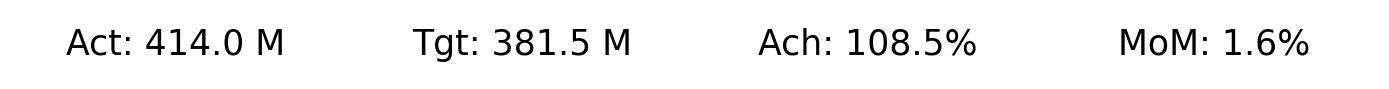

In [127]:
''' Monthly Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(mtd_act,',.1f')} M", size=25, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(mtd_tgt,',.1f')} M", size=25, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(mtd_achv,',.1%')}", size=25, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"MoM: {format(mtd_mom,',.1%')}", size=25, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

# ax1.text(0.5, 0.5, f"Act: {format(y_act.iloc[-1],',.1f')} M", size=25, ha='center', va='center')
# ax1.spines[['top','left','right','bottom']].set_visible(False)
# ax1.set_axis_off()

# ax2.text(0.5, 0.5, f"Tgt: {format(y_tgt.iloc[-1],',.1f')} M", size=25, ha='center', va='center')
# ax2.spines[['top','left','right','bottom']].set_visible(False)
# ax2.set_axis_off()

# ax3.text(0.5, 0.5, f"Ach: {format(y_achv.iloc[-1],',.1%')}", size=25, ha='center', va='center')
# ax3.spines[['top','left','right','bottom']].set_visible(False)
# ax3.set_axis_off()

# ax4.text(0.5, 0.5, f"MoM: {format(y_mom.iloc[-1],',.1%')}", size=25, ha='center', va='center')
# ax4.spines[['top','left','right','bottom']].set_visible(False)
# ax4.set_axis_off()

fig.tight_layout()
plt.show()

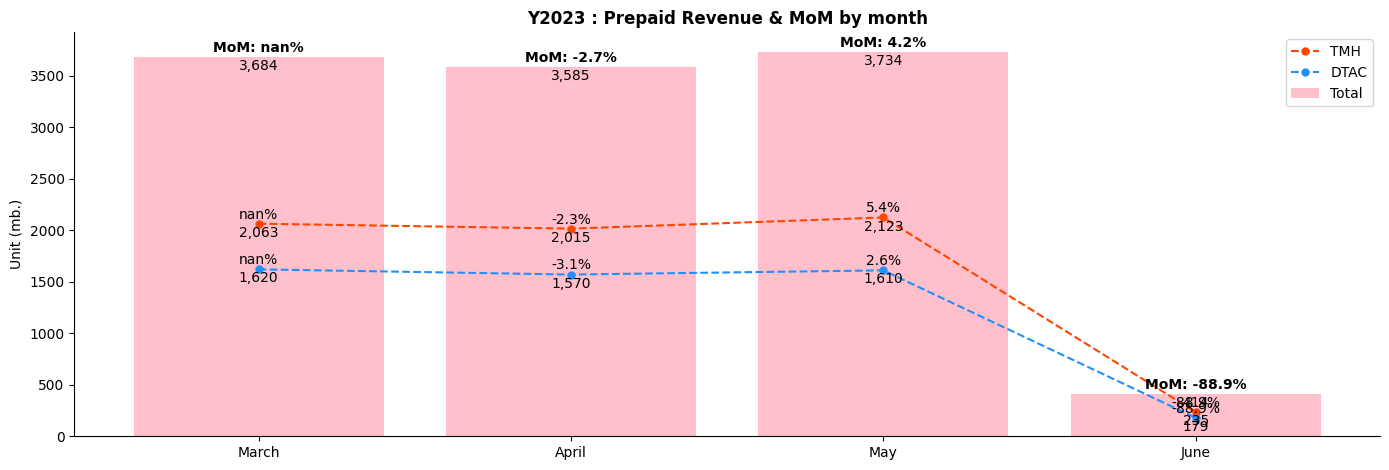

In [128]:
''' Revenue & MoM : MTH Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : Prepaid Revenue & MoM by month", weight='bold')
plt.bar(x_axis, y_act, label='Total', color='pink')
plt.plot(x_axis, y_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='TMH', color='orangered')
plt.plot(x_axis, y_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC', color='dodgerblue')
for i in x_axis:
    plt.annotate(f"MoM: {format(y_mom[i],',.1%')}", xy=(x_axis[i], y_act[i]+20), ha='center', va='bottom', weight='bold')
    plt.annotate(format(y_act[i],',.0f'), xy=(x_axis[i], y_act[i]-20), ha='center', va='top')
    plt.annotate(f"{format(y_mom_tmh[i],',.1%')}", xy=(x_axis[i], y_act_tmh[i]+20), ha='center', va='bottom')
    plt.annotate(format(y_act_tmh[i],',.0f'), xy=(x_axis[i], y_act_tmh[i]-20), ha='center', va='top')
    plt.annotate(f"{format(y_mom_dtac[i],',.1%')}", xy=(x_axis[i], y_act_dtac[i]+20), ha='center', va='bottom')
    plt.annotate(format(y_act_dtac[i],',.0f'), xy=(x_axis[i], y_act_dtac[i]-20), ha='center', va='top')
    
plt.ylabel('Unit (mb.)')
plt.xticks(x_axis, x)
plt.legend()
plt.tight_layout()
plt.show()

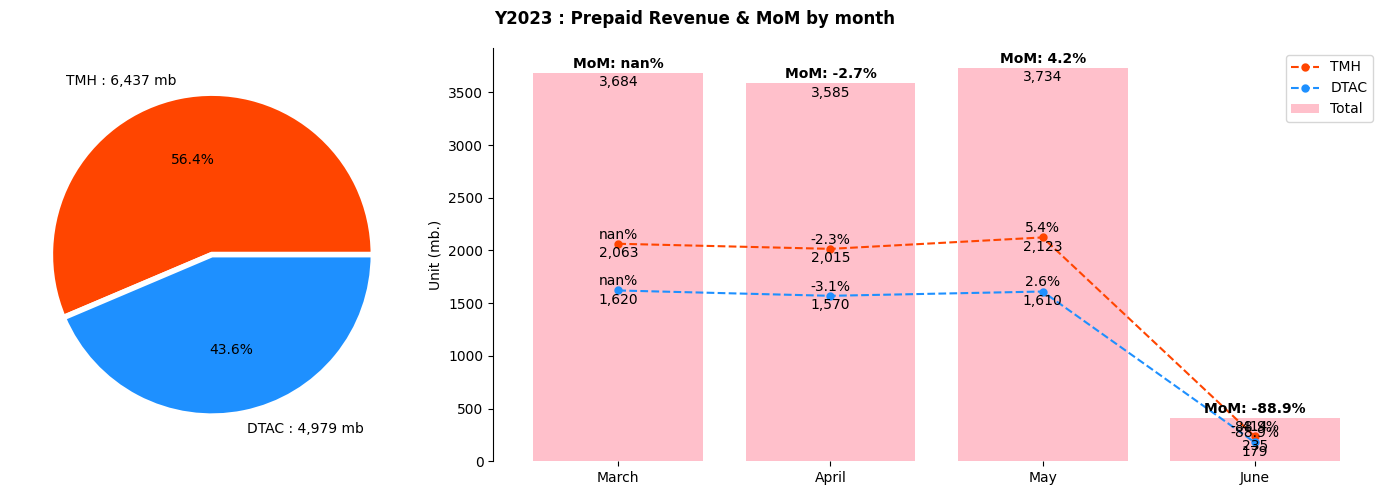

In [129]:
''' Revenue & MoM : MTH Chart (Temporaly) '''

fig = plt.figure(figsize=(14, 5))
fig.suptitle(f"Y{curr_yr} : Prepaid Revenue & MoM by month", weight='bold')
gs = GridSpec(1, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1:])

''' ax1 '''
y = np.array([sum(y_act_tmh), sum(y_act_dtac)])
mylabels = [f"TMH : {format(y[0],',.0f')} mb", f"DTAC : {format(y[1],',.0f')} mb"]
mycolors = ["orangered", "dodgerblue"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})

''' ax2 '''
ax2.spines[['top','right','bottom']].set_visible(False)
# ax2.spines['left'].set_linewidth(1.1)
# ax2.set_title('Revenue by month')
ax2.bar(x_axis, y_act, label='Total', color='pink')
ax2.plot(x_axis, y_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='TMH', color='orangered')
ax2.plot(x_axis, y_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC', color='dodgerblue')
for i in x_axis:
    ax2.annotate(f"MoM: {format(y_mom[i],',.1%')}", xy=(x_axis[i], y_act[i]+20), ha='center', va='bottom', weight='bold')
    ax2.annotate(format(y_act[i],',.0f'), xy=(x_axis[i], y_act[i]-20), ha='center', va='top')
    ax2.annotate(f"{format(y_mom_tmh[i],',.1%')}", xy=(x_axis[i], y_act_tmh[i]+20), ha='center', va='bottom')
    ax2.annotate(format(y_act_tmh[i],',.0f'), xy=(x_axis[i], y_act_tmh[i]-20), ha='center', va='top')
    ax2.annotate(f"{format(y_mom_dtac[i],',.1%')}", xy=(x_axis[i], y_act_dtac[i]+20), ha='center', va='bottom')
    ax2.annotate(format(y_act_dtac[i],',.0f'), xy=(x_axis[i], y_act_dtac[i]-20), ha='center', va='top')
ax2.set_ylabel('Unit (mb.)', fontsize=10)
ax2.legend()

# fig.patch.set_facecolor('white')
fig.tight_layout()
plt.xticks(x_axis, x)
plt.show()

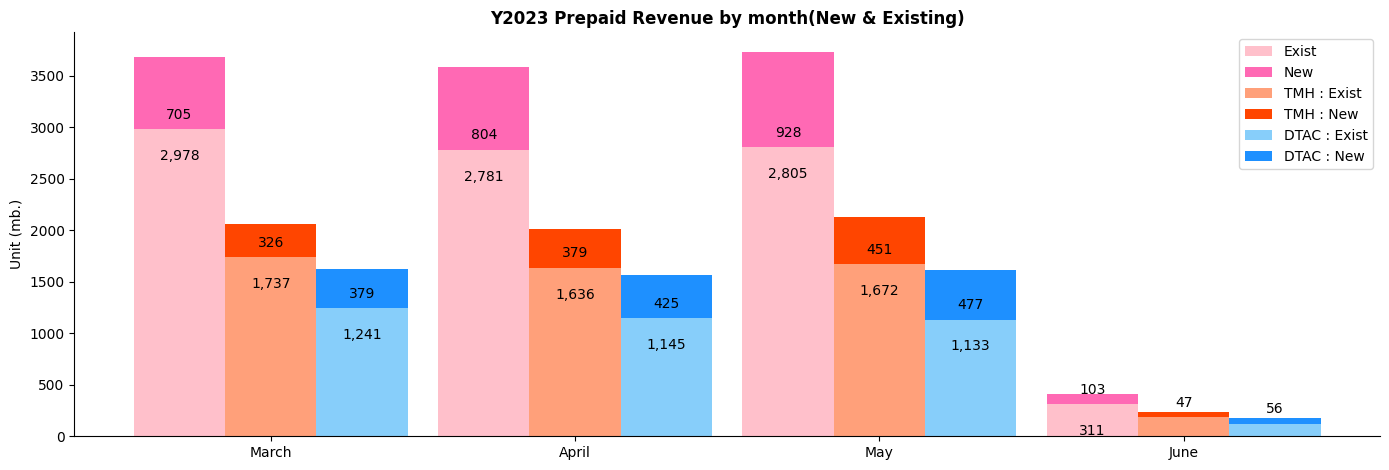

In [130]:
''' Revenue with New & Existing : MTH Chart '''

plt.figure().set_figwidth(14)

width = 0.3
diff_loc = 0.3
# f"Y{curr_yr} : Prepaid Revenue : {format(sum(y_act),',.0f')} mb", weight='bold'
plt.title(f'Y{curr_yr} Prepaid Revenue by month(New & Existing)', fontdict={'fontweight': 'bold'})
plt.bar(x_axis-diff_loc, y_act_exist, width, label='Exist', color='pink')
plt.bar(x_axis-diff_loc, y_act_new, width, label='New', color='hotpink', bottom=y_act_exist)
plt.bar(x_axis, y_act_exist_tmh, width, label='TMH : Exist', color='lightsalmon')
plt.bar(x_axis, y_act_new_tmh, width, label='TMH : New', color='orangered', bottom=y_act_exist_tmh)
plt.bar(x_axis+diff_loc, y_act_exist_dtac, width, label='DTAC : Exist', color='lightskyblue')
plt.bar(x_axis+diff_loc, y_act_new_dtac, width, label='DTAC : New', color='dodgerblue', bottom=y_act_exist_dtac)
for i in x_axis:    
    plt.annotate(format(y_act_exist[i],',.0f'), xy=(x_axis[i]-diff_loc, y_act_exist[i]-300), ha='center')
    plt.annotate(format(y_act_new[i],',.0f'), xy=(x_axis[i]-diff_loc, y_act_exist[i]+100), ha='center')
    plt.annotate(format(y_act_exist_tmh[i],',.0f'), xy=(x_axis[i], y_act_exist_tmh[i]-300), ha='center')
    plt.annotate(format(y_act_new_tmh[i],',.0f'), xy=(x_axis[i], y_act_exist_tmh[i]+100), ha='center')
    plt.annotate(format(y_act_exist_dtac[i],',.0f'), xy=(x_axis[i]+diff_loc, y_act_exist_dtac[i]-300), ha='center')
    plt.annotate(format(y_act_new_dtac[i],',.0f'), xy=(x_axis[i]+diff_loc, y_act_exist_dtac[i]+100), ha='center')

plt.ylabel('Unit (mb.)')
plt.xticks(x_axis, x)
plt.legend()
plt.tight_layout()
plt.show()

### MTH : Prepaid Revenue : TMH vs DTAC

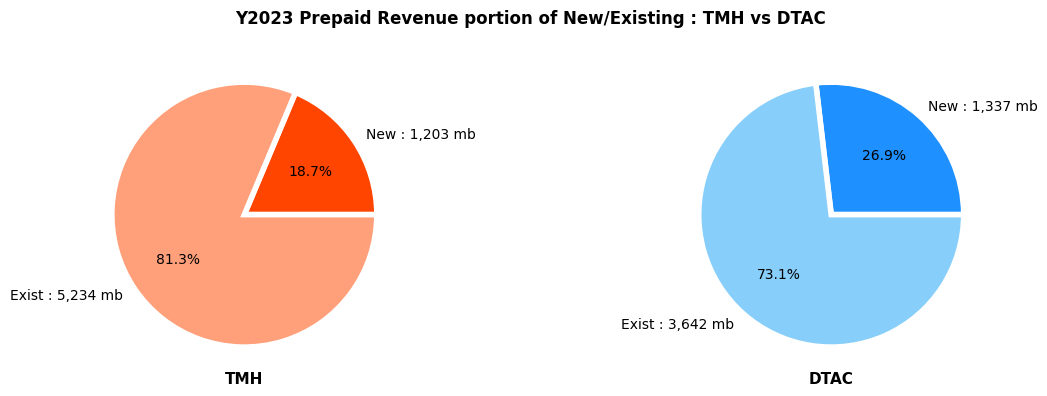

In [131]:
''' Revenue portion of New/Existing : TMH vs DTAC : MTH Chart '''

fig = plt.figure(figsize=(12, 4))
fig.suptitle(f'Y{curr_yr} Prepaid Revenue portion of New/Existing : TMH vs DTAC', weight='bold')
gs = GridSpec(1, 2)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])

''' ax1 '''
y = np.array([sum(y_act_new_tmh), sum(y_act_exist_tmh)])
mylabels = [f"New : {format(y[0],',.0f')} mb", f"Exist : {format(y[1],',.0f')} mb"]
mycolors = ["orangered", "lightsalmon"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax1.set_title('TMH', y=0, pad=-2, weight='bold', fontsize=11)

''' ax2 '''
y = np.array([sum(y_act_new_dtac), sum(y_act_exist_dtac)])
mylabels = [f"New : {format(y[0],',.0f')} mb", f"Exist : {format(y[1],',.0f')} mb"]
mycolors = ["dodgerblue", "lightskyblue"]
ax2.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax2.set_title('DTAC', y=0, pad=-2, weight='bold', fontsize=11)

fig.tight_layout()
plt.show()

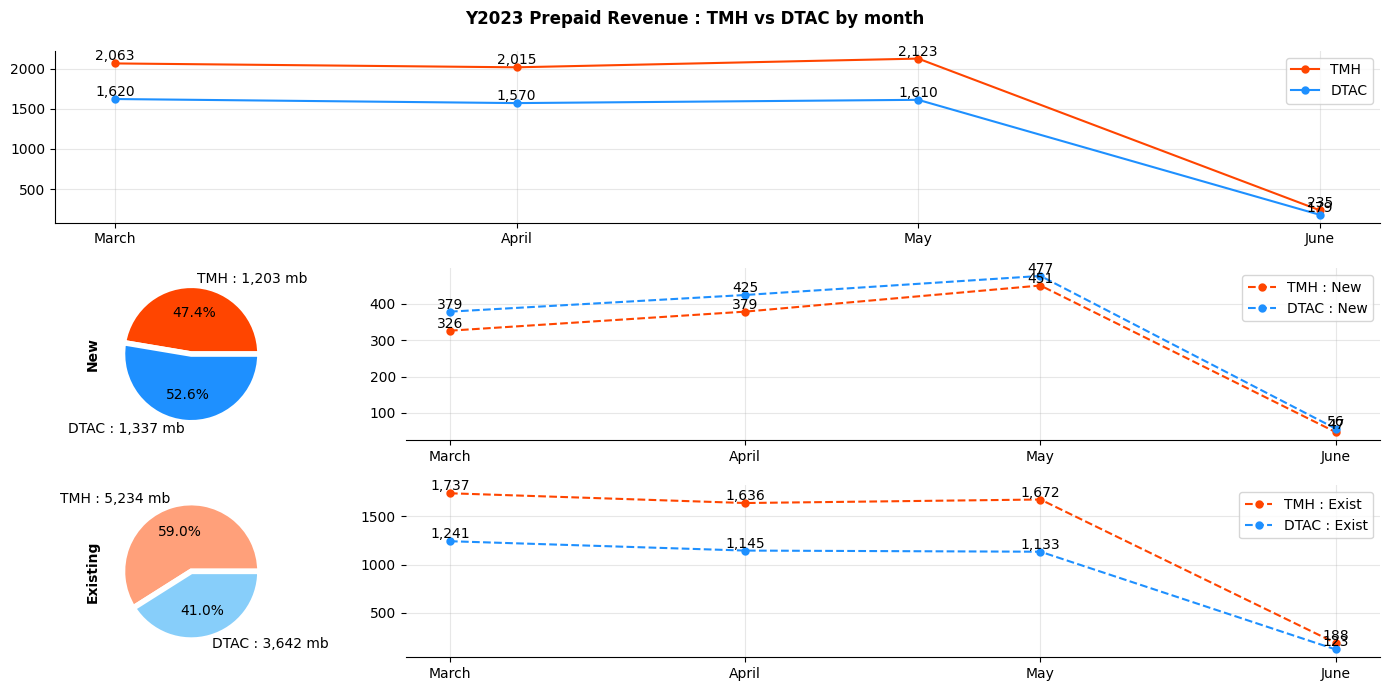

In [132]:
''' Revenue : TMH vs DTAC : MTH Chart '''

fig = plt.figure(figsize=(14, 7))
fig.suptitle(f'Y{curr_yr} Prepaid Revenue : TMH vs DTAC by month', weight='bold')
gs = GridSpec(3, 4)
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[2, 0])
ax3 = fig.add_subplot(gs[0, :])
ax4 = fig.add_subplot(gs[1, 1:])
ax5 = fig.add_subplot(gs[2, 1:])

''' ax1 '''
y = np.array([sum(y_act_new_tmh), sum(y_act_new_dtac)])
mylabels = [f"TMH : {format(y[0],',.0f')} mb", f"DTAC : {format(y[1],',.0f')} mb"]
mycolors = ["orangered", "dodgerblue"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax1.set_ylabel('New', weight='bold')

''' ax2 '''
y = np.array([sum(y_act_exist_tmh), sum(y_act_exist_dtac)])
mylabels = [f"TMH : {format(y[0],',.0f')} mb", f"DTAC : {format(y[1],',.0f')} mb"]
mycolors = ["lightsalmon", "lightskyblue"]
ax2.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax2.set_ylabel('Existing', weight='bold')

''' ax3 '''
ax3.plot(x_axis, y_act_tmh, marker='.', markeredgewidth=3, label='TMH', color='orangered')
ax3.plot(x_axis, y_act_dtac, marker='.', markeredgewidth=3, label='DTAC', color='dodgerblue')
ax3.legend()
ax3.grid(alpha=0.3)
ax3.set_xticks(x_axis, x)
ax3.spines[['top', 'right']].set_visible(False)
for i in x_axis:
    ax3.annotate(format(y_act_tmh[i],',.0f'), xy=(x_axis[i], y_act_tmh[i]), ha='center', va='bottom')
    ax3.annotate(format(y_act_dtac[i],',.0f'), xy=(x_axis[i], y_act_dtac[i]), ha='center', va='bottom')

''' ax4 '''
ax4.plot(x_axis, y_act_new_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='TMH : New', color='orangered')
ax4.plot(x_axis, y_act_new_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC : New', color='dodgerblue')
ax4.legend()
ax4.grid(alpha=0.3)
ax4.set_xticks(x_axis, x)
ax4.spines[['top', 'right', 'left']].set_visible(False)
for i in x_axis:
    ax4.annotate(format(y_act_new_tmh[i],',.0f'), xy=(x_axis[i], y_act_new_tmh[i]), ha='center', va='bottom')
    ax4.annotate(format(y_act_new_dtac[i],',.0f'), xy=(x_axis[i], y_act_new_dtac[i]), ha='center', va='bottom')

''' ax5 '''
ax5.plot(x_axis, y_act_exist_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='TMH : Exist', color='orangered')
ax5.plot(x_axis, y_act_exist_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC : Exist', color='dodgerblue')
ax5.legend()
ax5.grid(alpha=0.3)
ax5.set_xticks(x_axis, x)
ax5.spines[['top', 'right', 'left']].set_visible(False)
for i in x_axis:
    ax5.annotate(format(y_act_exist_tmh[i],',.0f'), xy=(x_axis[i], y_act_exist_tmh[i]), ha='center', va='bottom')
    ax5.annotate(format(y_act_exist_dtac[i],',.0f'), xy=(x_axis[i], y_act_exist_dtac[i]), ha='center', va='bottom')

# fig.supylabel('Revenue (mb.)', fontsize=10)
fig.tight_layout()
# plt.xticks(x_axis, x)
plt.show()

### MTH : Prepaid Performance : %Achievement & Gap

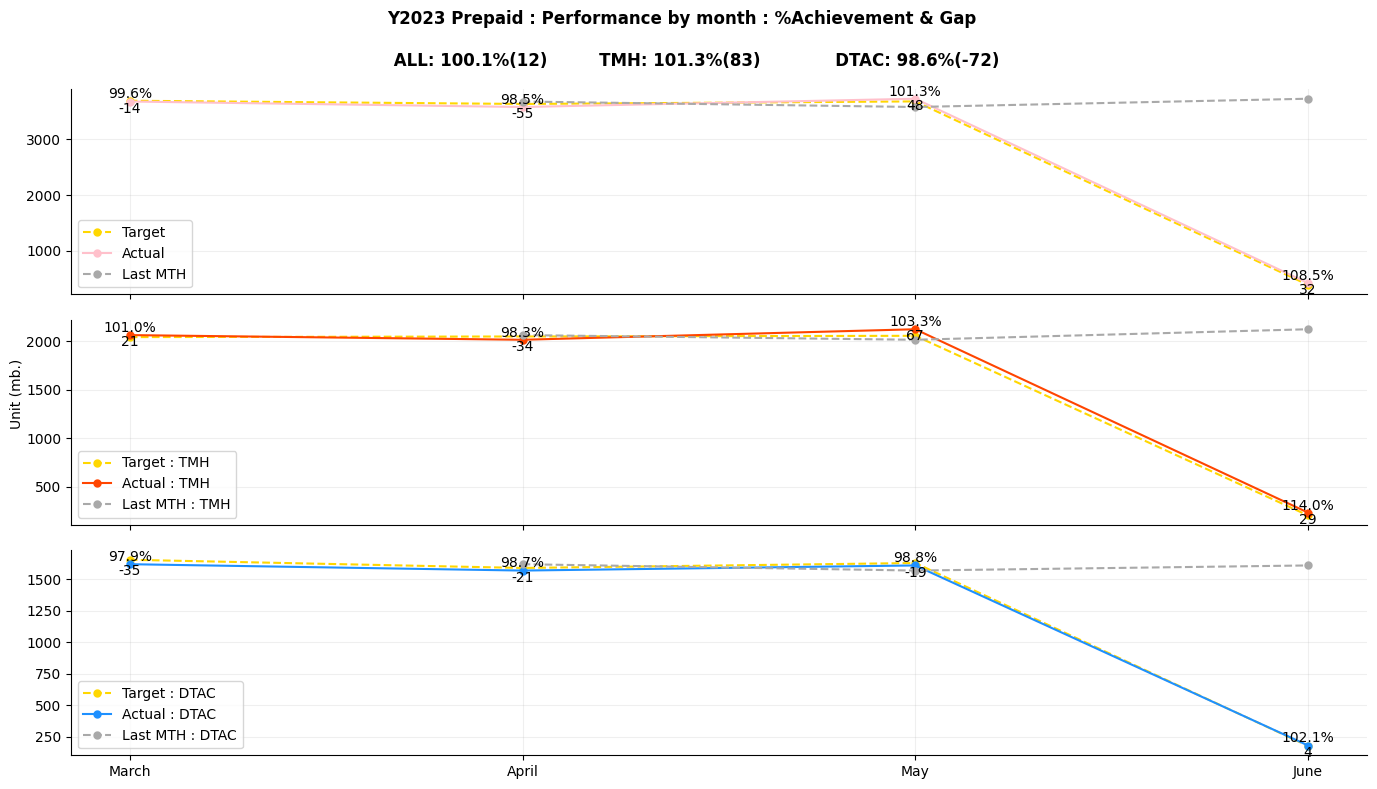

In [133]:
''' Peformance : %Achievement & Gap : MTH Chart '''

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(14, 8))
fig.suptitle(f"Y{curr_yr} Prepaid : Performance by month : %Achievement & Gap\n\n \
    ALL: {format(sum(y_act)/sum(y_tgt),',.1%')}({format(sum(y_gap),',.0f')}) \
        TMH: {format(sum(y_act_tmh)/sum(y_tgt_tmh),',.1%')}({format(sum(y_gap_tmh),',.0f')}) \
            DTAC: {format(sum(y_act_dtac)/sum(y_tgt_dtac),',.1%')}({format(sum(y_gap_dtac),',.0f')})", weight='bold')

''' ax1 '''
ax1.plot(x_axis, y_tgt, marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
ax1.plot(x_axis, y_act, marker='.', markeredgewidth=3, label='Actual', color='pink')
ax1.plot(x_axis, y_last_act, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH', color='darkgray')
ax1.legend()
ax1.grid(alpha=0.2)
for i in x_axis:
    ax1.annotate(format(y_achv[i],',.1%'), xy=(x_axis[i], y_act[i]+1), ha='center', va='bottom')
    ax1.annotate(format(y_gap[i],',.0f'), xy=(x_axis[i], y_act[i]-2), ha='center', va='top')

''' ax2 '''
ax2.plot(x_axis, y_tgt_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Target : TMH', color='gold')
ax2.plot(x_axis, y_act_tmh, marker='.', markeredgewidth=3, label='Actual : TMH', color='orangered')
ax2.plot(x_axis, y_last_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH : TMH', color='darkgray')
ax2.legend()
ax2.grid(alpha=0.2)
for i in x_axis:
    ax2.annotate(format(y_achv_tmh[i],',.1%'), xy=(x_axis[i], y_act_tmh[i]+1), ha='center', va='bottom')
    ax2.annotate(format(y_gap_tmh[i],',.0f'), xy=(x_axis[i], y_act_tmh[i]-2), ha='center', va='top')

''' ax3 '''
ax3.plot(x_axis, y_tgt_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Target : DTAC', color='gold')
ax3.plot(x_axis, y_act_dtac, marker='.', markeredgewidth=3, label='Actual : DTAC', color='dodgerblue')
ax3.plot(x_axis, y_last_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH : DTAC', color='darkgray')
ax3.legend()
ax3.grid(alpha=0.2)
for i in x_axis:
    ax3.annotate(format(y_achv_dtac[i],',.1%'), xy=(x_axis[i], y_act_dtac[i]+1), ha='center', va='bottom')
    ax3.annotate(format(y_gap_dtac[i],',.0f'), xy=(x_axis[i], y_act_dtac[i]-2), ha='center', va='top')

fig.supylabel('Unit (mb.)', fontsize=10)
fig.tight_layout()
plt.xticks(x_axis, x)
plt.show()

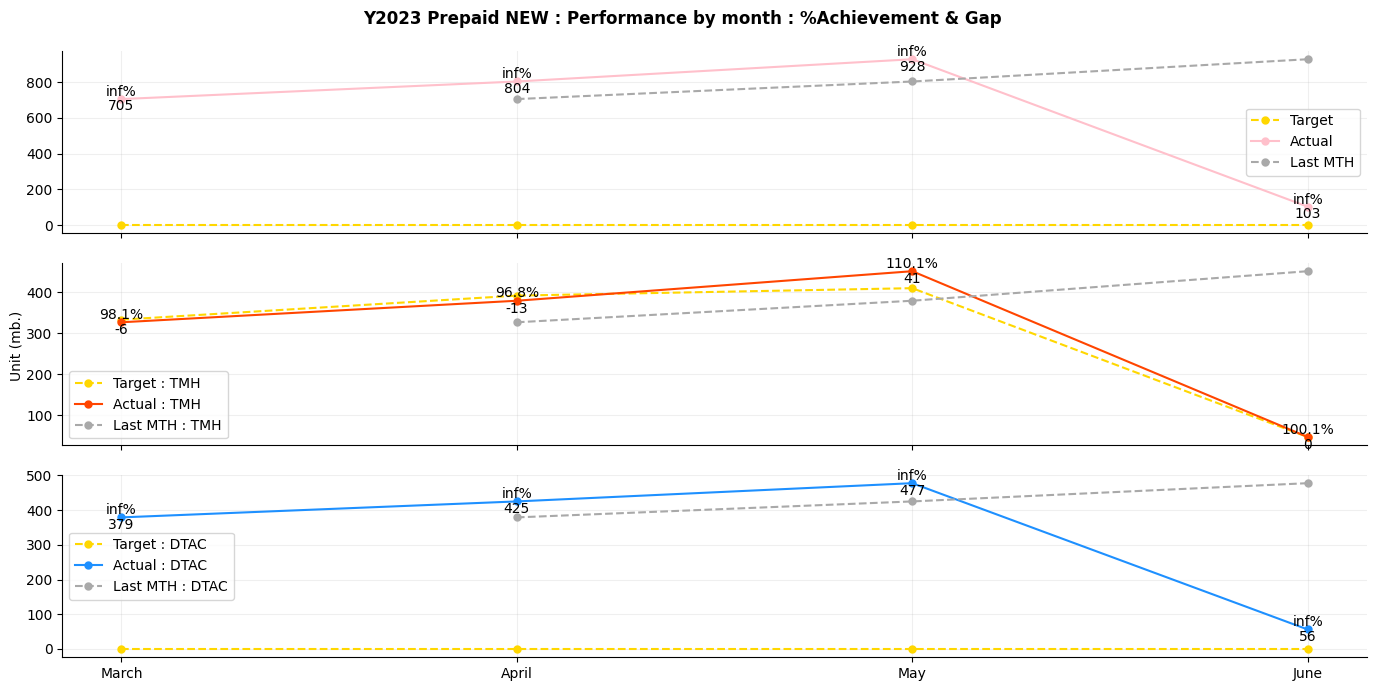

In [134]:
''' NEW : Peformance : %Achievement & Gap : MTH Chart '''
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(14, 7))
fig.suptitle(f'Y{curr_yr} Prepaid NEW : Performance by month : %Achievement & Gap', weight='bold')

''' ax1 '''
ax1.plot(x_axis, y_tgt_new, marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
ax1.plot(x_axis, y_act_new, marker='.', markeredgewidth=3, label='Actual', color='pink')
ax1.plot(x_axis, y_last_act_new, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH', color='darkgray')
ax1.legend()
ax1.grid(alpha=0.2)
for i in x_axis:
    ax1.annotate(format(y_achv_new[i],',.1%'), xy=(x_axis[i], y_act_new[i]+1), ha='center', va='bottom')
    ax1.annotate(format(y_gap_new[i],',.0f'), xy=(x_axis[i], y_act_new[i]-2), ha='center', va='top')

''' ax2 '''
ax2.plot(x_axis, y_tgt_new_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Target : TMH', color='gold')
ax2.plot(x_axis, y_act_new_tmh, marker='.', markeredgewidth=3, label='Actual : TMH', color='orangered')
ax2.plot(x_axis, y_last_act_new_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH : TMH', color='darkgray')
ax2.legend()
ax2.grid(alpha=0.2)
for i in x_axis:
    ax2.annotate(format(y_achv_new_tmh[i],',.1%'), xy=(x_axis[i], y_act_new_tmh[i]+1), ha='center', va='bottom')
    ax2.annotate(format(y_gap_new_tmh[i],',.0f'), xy=(x_axis[i], y_act_new_tmh[i]-2), ha='center', va='top')

''' ax3 '''
ax3.plot(x_axis, y_tgt_new_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Target : DTAC', color='gold')
ax3.plot(x_axis, y_act_new_dtac, marker='.', markeredgewidth=3, label='Actual : DTAC', color='dodgerblue')
ax3.plot(x_axis, y_last_act_new_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH : DTAC', color='darkgray')
ax3.legend()
ax3.grid(alpha=0.2)
for i in x_axis:
    ax3.annotate(format(y_achv_new_dtac[i],',.1%'), xy=(x_axis[i], y_act_new_dtac[i]+1), ha='center', va='bottom')
    ax3.annotate(format(y_gap_new_dtac[i],',.0f'), xy=(x_axis[i], y_act_new_dtac[i]-2), ha='center', va='top')

fig.supylabel('Unit (mb.)', fontsize=10)
fig.tight_layout()
plt.xticks(x_axis, x)
plt.show()

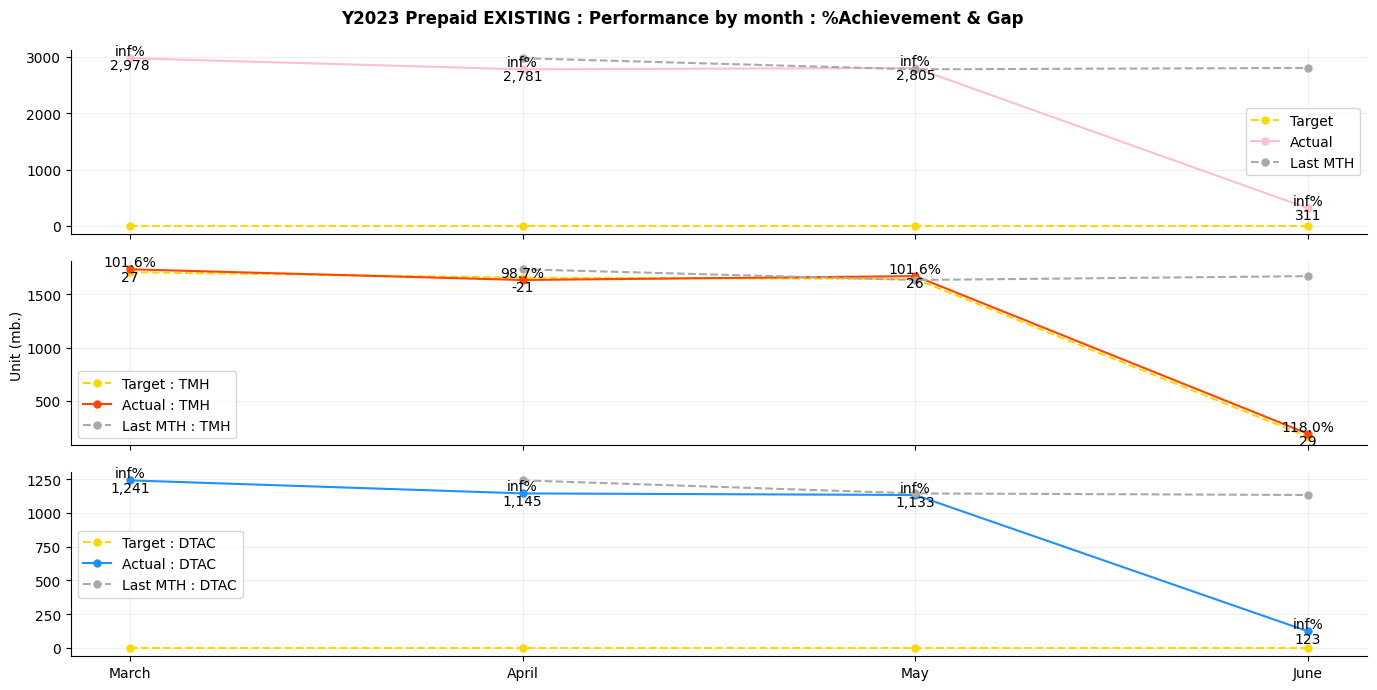

In [135]:
''' EXISTING : Peformance : %Achievement & Gap : MTH Chart '''
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(14, 7))
fig.suptitle(f'Y{curr_yr} Prepaid EXISTING : Performance by month : %Achievement & Gap', weight='bold')

''' ax1 '''
ax1.plot(x_axis, y_tgt_exist, marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
ax1.plot(x_axis, y_act_exist, marker='.', markeredgewidth=3, label='Actual', color='pink')
ax1.plot(x_axis, y_last_act_exist, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH', color='darkgray')
ax1.legend()
ax1.grid(alpha=0.2)
for i in x_axis:
    ax1.annotate(format(y_achv_exist[i],',.1%'), xy=(x_axis[i], y_act_exist[i]+1), ha='center', va='bottom')
    ax1.annotate(format(y_gap_exist[i],',.0f'), xy=(x_axis[i], y_act_exist[i]-2), ha='center', va='top')

''' ax2 '''
ax2.plot(x_axis, y_tgt_exist_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Target : TMH', color='gold')
ax2.plot(x_axis, y_act_exist_tmh, marker='.', markeredgewidth=3, label='Actual : TMH', color='orangered')
ax2.plot(x_axis, y_last_act_exist_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH : TMH', color='darkgray')
ax2.legend()
ax2.grid(alpha=0.2)
for i in x_axis:
    ax2.annotate(format(y_achv_exist_tmh[i],',.1%'), xy=(x_axis[i], y_act_exist_tmh[i]+1), ha='center', va='bottom')
    ax2.annotate(format(y_gap_exist_tmh[i],',.0f'), xy=(x_axis[i], y_act_exist_tmh[i]-2), ha='center', va='top')

''' ax3 '''
ax3.plot(x_axis, y_tgt_exist_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Target : DTAC', color='gold')
ax3.plot(x_axis, y_act_exist_dtac, marker='.', markeredgewidth=3, label='Actual : DTAC', color='dodgerblue')
ax3.plot(x_axis, y_last_act_exist_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH : DTAC', color='darkgray')
ax3.legend()
ax3.grid(alpha=0.2)
for i in x_axis:
    ax3.annotate(format(y_achv_exist_dtac[i],',.1%'), xy=(x_axis[i], y_act_exist_dtac[i]+1), ha='center', va='bottom')
    ax3.annotate(format(y_gap_exist_dtac[i],',.0f'), xy=(x_axis[i], y_act_exist_dtac[i]-2), ha='center', va='top')

fig.supylabel('Unit (mb.)', fontsize=10)
fig.tight_layout()
plt.xticks(x_axis, x)
plt.show()

## ** Weekly

### WK : Aggregation

In [136]:
''' Aggregate by week '''
df_rev_pivot_agg_curr_yr = df_rev_pivot_agg[df_rev_pivot_agg['TM_KEY_YR']==curr_yr]
df_rev_wk = df_rev_pivot_agg_curr_yr.groupby('WK_LABEL')\
    .sum(numeric_only=True)[['ACTUAL', 'ACTUAL_DTAC', 'ACTUAL_TMH', 'TARGET', 'TARGET_DTAC', 'TARGET_TMH', 
                             'ACTUAL_NEW', 'ACTUAL_NEW_DTAC', 'ACTUAL_NEW_TMH', 'TARGET_NEW', 'TARGET_NEW_DTAC', 'TARGET_NEW_TMH', 
                             'ACTUAL_EXIST', 'ACTUAL_EXIST_DTAC', 'ACTUAL_EXIST_TMH', 'TARGET_EXIST', 'TARGET_EXIST_DTAC', 'TARGET_EXIST_TMH']].reset_index()

''' Aggregation '''
df_rev_wk['%ACHV'] = (df_rev_wk['ACTUAL'] / df_rev_wk['TARGET'])
df_rev_wk['%ACHV_DTAC'] = (df_rev_wk['ACTUAL_DTAC'] / df_rev_wk['TARGET_DTAC'])
df_rev_wk['%ACHV_TMH'] = (df_rev_wk['ACTUAL_TMH'] / df_rev_wk['TARGET_TMH'])
df_rev_wk['GAP'] = df_rev_wk['ACTUAL'] - df_rev_wk['TARGET']
df_rev_wk['GAP_DTAC'] = df_rev_wk['ACTUAL_DTAC'] - df_rev_wk['TARGET_DTAC']
df_rev_wk['GAP_TMH'] = df_rev_wk['ACTUAL_TMH'] - df_rev_wk['TARGET_TMH']
df_rev_wk['DIFF'] = df_rev_wk['ACTUAL'].diff()
df_rev_wk['DIFF_DTAC'] = df_rev_wk['ACTUAL_DTAC'].diff()
df_rev_wk['DIFF_TMH'] = df_rev_wk['ACTUAL_TMH'].diff()
df_rev_wk['LAST_ACT'] = df_rev_wk['ACTUAL'] - df_rev_wk['DIFF']
df_rev_wk['LAST_ACT_DTAC'] = df_rev_wk['ACTUAL_DTAC'] - df_rev_wk['DIFF_DTAC']
df_rev_wk['LAST_ACT_TMH'] = df_rev_wk['ACTUAL_TMH'] - df_rev_wk['DIFF_TMH']
df_rev_wk['%WOW'] = (df_rev_wk['ACTUAL'] / df_rev_wk['LAST_ACT']) - 1
df_rev_wk['%WOW_DTAC'] = (df_rev_wk['ACTUAL_DTAC'] / df_rev_wk['LAST_ACT_DTAC']) - 1
df_rev_wk['%WOW_TMH'] = (df_rev_wk['ACTUAL_TMH'] / df_rev_wk['LAST_ACT_TMH']) - 1

''' NEW : Aggregation '''
df_rev_wk['%ACHV_NEW'] = (df_rev_wk['ACTUAL_NEW'] / df_rev_wk['TARGET_NEW'])
df_rev_wk['%ACHV_NEW_DTAC'] = (df_rev_wk['ACTUAL_NEW_DTAC'] / df_rev_wk['TARGET_NEW_DTAC'])
df_rev_wk['%ACHV_NEW_TMH'] = (df_rev_wk['ACTUAL_NEW_TMH'] / df_rev_wk['TARGET_NEW_TMH'])
df_rev_wk['GAP_NEW'] = df_rev_wk['ACTUAL_NEW'] - df_rev_wk['TARGET_NEW']
df_rev_wk['GAP_NEW_DTAC'] = df_rev_wk['ACTUAL_NEW_DTAC'] - df_rev_wk['TARGET_NEW_DTAC']
df_rev_wk['GAP_NEW_TMH'] = df_rev_wk['ACTUAL_NEW_TMH'] - df_rev_wk['TARGET_NEW_TMH']
df_rev_wk['DIFF_NEW'] = df_rev_wk['ACTUAL_NEW'].diff()
df_rev_wk['DIFF_NEW_DTAC'] = df_rev_wk['ACTUAL_NEW_DTAC'].diff()
df_rev_wk['DIFF_NEW_TMH'] = df_rev_wk['ACTUAL_NEW_TMH'].diff()
df_rev_wk['LAST_ACT_NEW'] = df_rev_wk['ACTUAL_NEW'] - df_rev_wk['DIFF_NEW']
df_rev_wk['LAST_ACT_NEW_DTAC'] = df_rev_wk['ACTUAL_NEW_DTAC'] - df_rev_wk['DIFF_NEW_DTAC']
df_rev_wk['LAST_ACT_NEW_TMH'] = df_rev_wk['ACTUAL_NEW_TMH'] - df_rev_wk['DIFF_NEW_TMH']
df_rev_wk['%WOW_NEW'] = (df_rev_wk['ACTUAL_NEW'] / df_rev_wk['LAST_ACT_NEW']) - 1
df_rev_wk['%WOW_NEW_DTAC'] = (df_rev_wk['ACTUAL_NEW_DTAC'] / df_rev_wk['LAST_ACT_NEW_DTAC']) - 1
df_rev_wk['%WOW_NEW_TMH'] = (df_rev_wk['ACTUAL_NEW_TMH'] / df_rev_wk['LAST_ACT_NEW_TMH']) - 1

''' EXIST : Aggregation '''
df_rev_wk['%ACHV_EXIST'] = (df_rev_wk['ACTUAL_EXIST'] / df_rev_wk['TARGET_EXIST'])
df_rev_wk['%ACHV_EXIST_DTAC'] = (df_rev_wk['ACTUAL_EXIST_DTAC'] / df_rev_wk['TARGET_EXIST_DTAC'])
df_rev_wk['%ACHV_EXIST_TMH'] = (df_rev_wk['ACTUAL_EXIST_TMH'] / df_rev_wk['TARGET_EXIST_TMH'])
df_rev_wk['GAP_EXIST'] = df_rev_wk['ACTUAL_EXIST'] - df_rev_wk['TARGET_EXIST']
df_rev_wk['GAP_EXIST_DTAC'] = df_rev_wk['ACTUAL_EXIST_DTAC'] - df_rev_wk['TARGET_EXIST_DTAC']
df_rev_wk['GAP_EXIST_TMH'] = df_rev_wk['ACTUAL_EXIST_TMH'] - df_rev_wk['TARGET_EXIST_TMH']
df_rev_wk['DIFF_EXIST'] = df_rev_wk['ACTUAL_EXIST'].diff()
df_rev_wk['DIFF_EXIST_DTAC'] = df_rev_wk['ACTUAL_EXIST_DTAC'].diff()
df_rev_wk['DIFF_EXIST_TMH'] = df_rev_wk['ACTUAL_EXIST_TMH'].diff()
df_rev_wk['LAST_ACT_EXIST'] = df_rev_wk['ACTUAL_EXIST'] - df_rev_wk['DIFF_EXIST']
df_rev_wk['LAST_ACT_EXIST_DTAC'] = df_rev_wk['ACTUAL_EXIST_DTAC'] - df_rev_wk['DIFF_EXIST_DTAC']
df_rev_wk['LAST_ACT_EXIST_TMH'] = df_rev_wk['ACTUAL_EXIST_TMH'] - df_rev_wk['DIFF_EXIST_TMH']
df_rev_wk['%WOW_EXIST'] = (df_rev_wk['ACTUAL_EXIST'] / df_rev_wk['LAST_ACT_EXIST']) - 1
df_rev_wk['%WOW_EXIST_DTAC'] = (df_rev_wk['ACTUAL_EXIST_DTAC'] / df_rev_wk['LAST_ACT_EXIST_DTAC']) - 1
df_rev_wk['%WOW_EXIST_TMH'] = (df_rev_wk['ACTUAL_EXIST_TMH'] / df_rev_wk['LAST_ACT_EXIST_TMH']) - 1

df_rev_wk.tail(3)
# df_rev_wk.to_excel("temp.xlsx")

METRIC_NAME,WK_LABEL,ACTUAL,ACTUAL_DTAC,ACTUAL_TMH,TARGET,TARGET_DTAC,TARGET_TMH,ACTUAL_NEW,ACTUAL_NEW_DTAC,ACTUAL_NEW_TMH,...,GAP_EXIST_TMH,DIFF_EXIST,DIFF_EXIST_DTAC,DIFF_EXIST_TMH,LAST_ACT_EXIST,LAST_ACT_EXIST_DTAC,LAST_ACT_EXIST_TMH,%WOW_EXIST,%WOW_EXIST_DTAC,%WOW_EXIST_TMH
11,20,809.668670,349.633265,460.035405,819.748714,355.494948,464.253766,205.427121,105.198108,100.229014,...,-11.962145,-4.215469,-3.030098,-1.185371,608.457017,247.465255,360.991762,-0.006928,-0.012245,-0.003284
12,21,817.699159,350.000495,467.698664,814.678824,350.425058,464.253766,211.173023,108.796178,102.376845,...,-6.446717,2.284588,-3.230840,5.515428,604.241548,244.435157,359.806391,0.003781,-0.013218,0.015329
13,22,823.537049,349.235233,474.301816,749.997245,344.745201,405.252045,202.362371,106.281573,96.080798,...,59.138278,14.648542,1.749343,12.899199,606.526136,241.204317,365.321819,0.024152,0.007253,0.035309


In [137]:
''' Week Chart Values '''
x = df_rev_wk['WK_LABEL']
x_axis = np.arange(len(x))

''' Values '''
y_act = df_rev_wk['ACTUAL'].round(2)
y_act_dtac = df_rev_wk['ACTUAL_DTAC'].round(2)
y_act_tmh = df_rev_wk['ACTUAL_TMH'].round(2)
y_tgt = df_rev_wk['TARGET'].round(2)
y_tgt_dtac = df_rev_wk['TARGET_DTAC'].round(2)
y_tgt_tmh = df_rev_wk['TARGET_TMH'].round(2)
y_achv = df_rev_wk['%ACHV']
y_achv_dtac = df_rev_wk['%ACHV_DTAC']
y_achv_tmh = df_rev_wk['%ACHV_TMH']
y_gap = df_rev_wk['GAP'].round(2)
y_gap_dtac = df_rev_wk['GAP_DTAC'].round(2)
y_gap_tmh = df_rev_wk['GAP_TMH'].round(2)
y_diff = df_rev_wk['DIFF'].round(2)
y_diff_dtac = df_rev_wk['DIFF_DTAC'].round(2)
y_diff_tmh = df_rev_wk['DIFF_TMH'].round(2)
y_last_act = df_rev_wk['LAST_ACT'].round(2)
y_last_act_dtac = df_rev_wk['LAST_ACT_DTAC'].round(2)
y_last_act_tmh = df_rev_wk['LAST_ACT_TMH'].round(2)
y_wow = df_rev_wk['%WOW']
y_wow_dtac = df_rev_wk['%WOW_DTAC']
y_wow_tmh = df_rev_wk['%WOW_TMH']

''' NEW : Values '''
y_act_new = df_rev_wk['ACTUAL_NEW'].round(2)
y_act_new_dtac = df_rev_wk['ACTUAL_NEW_DTAC'].round(2)
y_act_new_tmh = df_rev_wk['ACTUAL_NEW_TMH'].round(2)
y_tgt_new = df_rev_wk['TARGET_NEW'].round(2)
y_tgt_new_dtac = df_rev_wk['TARGET_NEW_DTAC'].round(2)
y_tgt_new_tmh = df_rev_wk['TARGET_NEW_TMH'].round(2)
y_achv_new = df_rev_wk['%ACHV_NEW']
y_achv_new_dtac = df_rev_wk['%ACHV_NEW_DTAC']
y_achv_new_tmh = df_rev_wk['%ACHV_NEW_TMH']
y_gap_new = df_rev_wk['GAP_NEW'].round(2)
y_gap_new_dtac = df_rev_wk['GAP_NEW_DTAC'].round(2)
y_gap_new_tmh = df_rev_wk['GAP_NEW_TMH'].round(2)
y_diff_new = df_rev_wk['DIFF_NEW'].round(2)
y_diff_new_dtac = df_rev_wk['DIFF_NEW_DTAC'].round(2)
y_diff_new_tmh = df_rev_wk['DIFF_NEW_TMH'].round(2)
y_last_act_new = df_rev_wk['LAST_ACT_NEW'].round(2)
y_last_act_new_dtac = df_rev_wk['LAST_ACT_NEW_DTAC'].round(2)
y_last_act_new_tmh = df_rev_wk['LAST_ACT_NEW_TMH'].round(2)
y_wow_new = df_rev_wk['%WOW_NEW']
y_wow_new_dtac = df_rev_wk['%WOW_NEW_DTAC']
y_wow_new_tmh = df_rev_wk['%WOW_NEW_TMH']

''' EXIST : Values '''
y_act_exist = df_rev_wk['ACTUAL_EXIST'].round(2)
y_act_exist_dtac = df_rev_wk['ACTUAL_EXIST_DTAC'].round(2)
y_act_exist_tmh = df_rev_wk['ACTUAL_EXIST_TMH'].round(2)
y_tgt_exist = df_rev_wk['TARGET_EXIST'].round(2)
y_tgt_exist_dtac = df_rev_wk['TARGET_EXIST_DTAC'].round(2)
y_tgt_exist_tmh = df_rev_wk['TARGET_EXIST_TMH'].round(2)
y_achv_exist = df_rev_wk['%ACHV_EXIST']
y_achv_exist_dtac = df_rev_wk['%ACHV_EXIST_DTAC']
y_achv_exist_tmh = df_rev_wk['%ACHV_EXIST_TMH']
y_gap_exist = df_rev_wk['GAP_EXIST'].round(2)
y_gap_exist_dtac = df_rev_wk['GAP_EXIST_DTAC'].round(2)
y_gap_exist_tmh = df_rev_wk['GAP_EXIST_TMH'].round(2)
y_diff_exist = df_rev_wk['DIFF_EXIST'].round(2)
y_diff_exist_dtac = df_rev_wk['DIFF_EXIST_DTAC'].round(2)
y_diff_exist_tmh = df_rev_wk['DIFF_EXIST_TMH'].round(2)
y_last_act_exist = df_rev_wk['LAST_ACT_EXIST'].round(2)
y_last_act_exist_dtac = df_rev_wk['LAST_ACT_EXIST_DTAC'].round(2)
y_last_act_exist_tmh = df_rev_wk['LAST_ACT_EXIST_TMH'].round(2)
y_wow_exist = df_rev_wk['%WOW_EXIST']
y_wow_exist_dtac = df_rev_wk['%WOW_EXIST_DTAC']
y_wow_exist_tmh = df_rev_wk['%WOW_EXIST_TMH']

### WK : Prepaid Revenue Summary

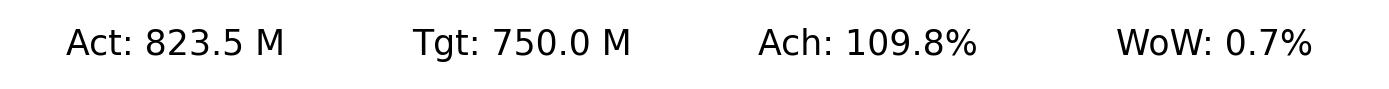

In [138]:
''' Weekly Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(y_act.iloc[-1],',.1f')} M", size=25, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(y_tgt.iloc[-1],',.1f')} M", size=25, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(y_achv.iloc[-1],',.1%')}", size=25, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"WoW: {format(y_wow.iloc[-1],',.1%')}", size=25, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

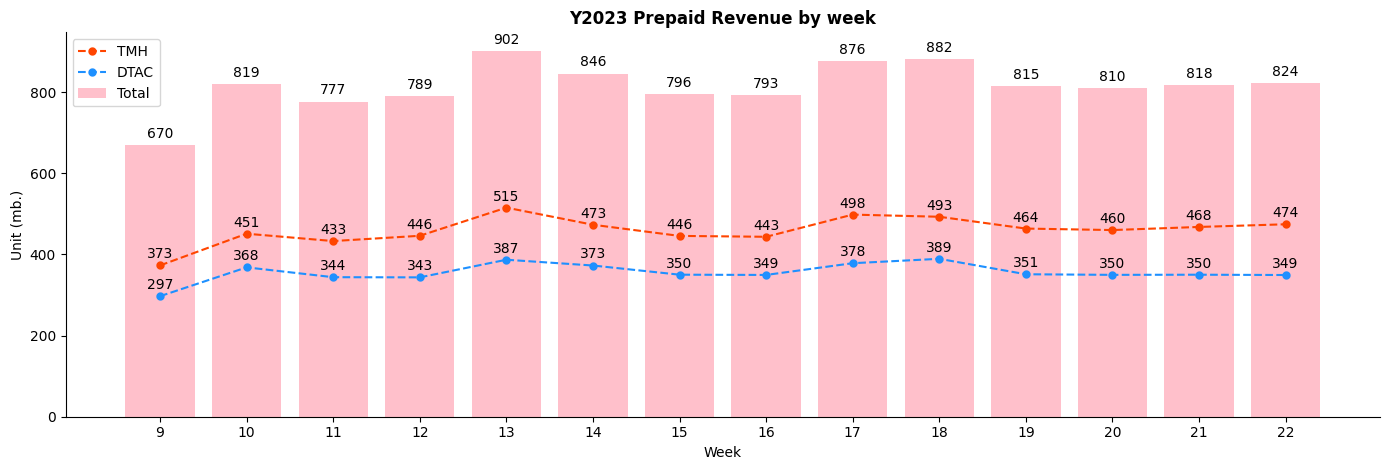

In [139]:
''' Revenue by week '''

plt.figure().set_figwidth(14)

plt.title(f'Y{curr_yr} Prepaid Revenue by week', fontdict={'fontweight': 'bold'})
plt.bar(x_axis, y_act, label='Total', color='pink')
plt.plot(x_axis, y_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='TMH', color='orangered')
plt.plot(x_axis, y_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC', color='dodgerblue')
for i in x_axis:
    plt.annotate(format(y_act[i],',.0f'), xy=(x_axis[i], y_act[i]+10), ha='center', va='bottom')
    plt.annotate(format(y_act_tmh[i],',.0f'), xy=(x_axis[i], y_act_tmh[i]+10), ha='center', va='bottom')
    plt.annotate(format(y_act_dtac[i],',.0f'), xy=(x_axis[i], y_act_dtac[i]+10), ha='center', va='bottom')
plt.xlabel('Week')
plt.ylabel('Unit (mb.)')
plt.xticks(x_axis, x)
plt.legend()
plt.tight_layout()
plt.show()

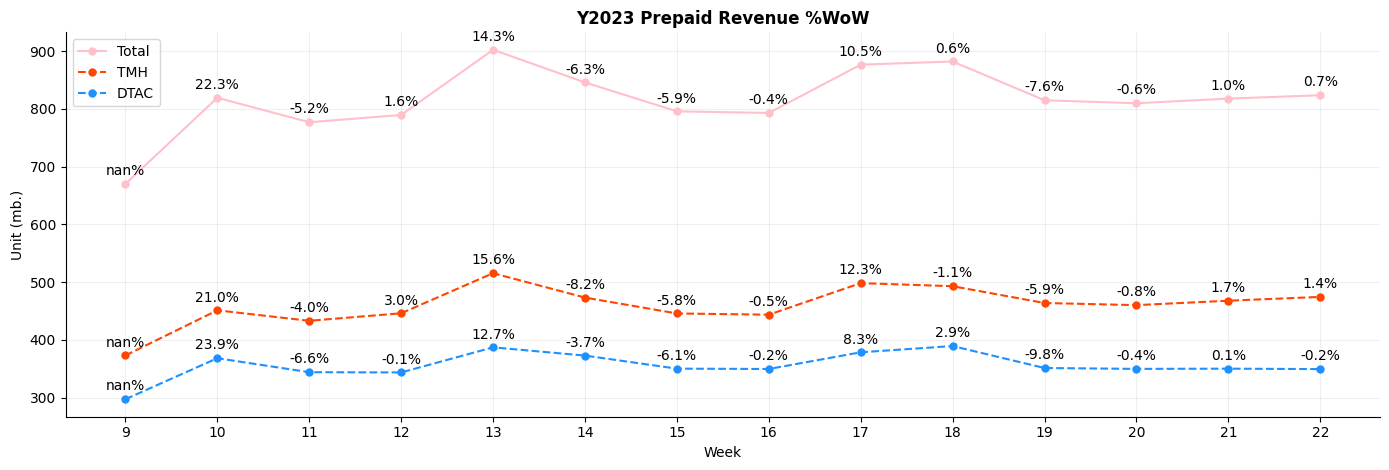

In [140]:
''' Revenue %WoW '''

plt.figure().set_figwidth(14)

plt.title(f'Y{curr_yr} Prepaid Revenue %WoW', fontdict={'fontweight': 'bold'})
plt.plot(x_axis, y_act, marker='.', markeredgewidth=3, label='Total', color='pink')
plt.plot(x_axis, y_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='TMH', color='orangered')
plt.plot(x_axis, y_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC', color='dodgerblue')
for i in x_axis:
    plt.annotate(f"{format(y_wow[i],',.1%')}", xy=(x_axis[i], y_act[i]+10), ha='center', va='bottom')
    plt.annotate(f"{format(y_wow_tmh[i],',.1%')}", xy=(x_axis[i], y_act_tmh[i]+10), ha='center', va='bottom')
    plt.annotate(f"{format(y_wow_dtac[i],',.1%')}", xy=(x_axis[i], y_act_dtac[i]+10), ha='center', va='bottom')
plt.xlabel('Week')
plt.ylabel('Unit (mb.)')
plt.xticks(x_axis, x)
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()

### WK : Prepaid Performance : %Achievement & Gap

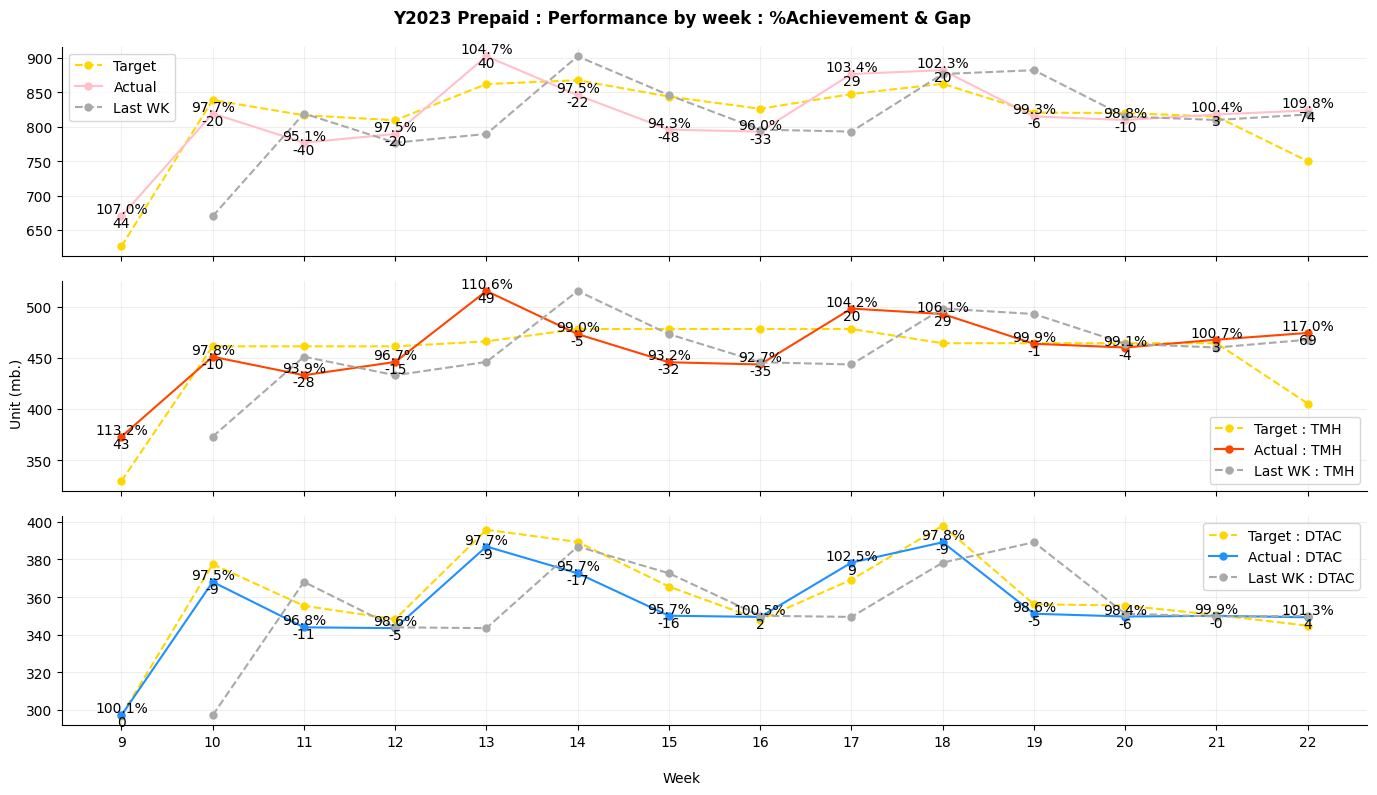

In [141]:
''' Peformance : %Achievement & Gap : Week Chart '''

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(14, 8))
fig.suptitle(f"Y{curr_yr} Prepaid : Performance by week : %Achievement & Gap", weight='bold')

''' ax1 '''
ax1.plot(x_axis, y_tgt, marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
ax1.plot(x_axis, y_act, marker='.', markeredgewidth=3, label='Actual', color='pink')
ax1.plot(x_axis, y_last_act, marker='.', linestyle='dashed', markeredgewidth=3, label='Last WK', color='darkgray')
ax1.legend()
# ax1.legend(loc='lower left')
ax1.grid(alpha=0.2)
for i in x_axis:
    ax1.annotate(format(y_achv[i],',.1%'), xy=(x_axis[i], y_act[i]), ha='center', va='bottom')
    ax1.annotate(format(y_gap[i],',.0f'), xy=(x_axis[i], y_act[i]), ha='center', va='top')

''' ax2 '''
ax2.plot(x_axis, y_tgt_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Target : TMH', color='gold')
ax2.plot(x_axis, y_act_tmh, marker='.', markeredgewidth=3, label='Actual : TMH', color='orangered')
ax2.plot(x_axis, y_last_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Last WK : TMH', color='darkgray')
ax2.legend()
ax2.grid(alpha=0.2)
for i in x_axis:
    ax2.annotate(format(y_achv_tmh[i],',.1%'), xy=(x_axis[i], y_act_tmh[i]), ha='center', va='bottom')
    ax2.annotate(format(y_gap_tmh[i],',.0f'), xy=(x_axis[i], y_act_tmh[i]), ha='center', va='top')

''' ax3 '''
ax3.plot(x_axis, y_tgt_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Target : DTAC', color='gold')
ax3.plot(x_axis, y_act_dtac, marker='.', markeredgewidth=3, label='Actual : DTAC', color='dodgerblue')
ax3.plot(x_axis, y_last_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Last WK : DTAC', color='darkgray')
ax3.legend()
ax3.grid(alpha=0.2)
for i in x_axis:
    ax3.annotate(format(y_achv_dtac[i],',.1%'), xy=(x_axis[i], y_act_dtac[i]), ha='center', va='bottom')
    ax3.annotate(format(y_gap_dtac[i],',.0f'), xy=(x_axis[i], y_act_dtac[i]), ha='center', va='top')

fig.supxlabel('Week', fontsize=10)
fig.supylabel('Unit (mb.)', fontsize=10)
fig.tight_layout()
plt.xticks(x_axis, x)
plt.show()

## ** Daily (MTD)

### DAY : Aggregation

In [142]:
''' Aggregate by day '''

df_rev_pivot_agg_last_mth = df_rev_pivot_agg.loc[df_rev_pivot_agg[df_rev_pivot_agg['TM_KEY_MTH']==last_mth].groupby('TM_KEY_MTH')['TM_KEY_DAY'].idxmax()]
# df_rev_pivot_agg_last_mth = df_rev_pivot_agg[df_rev_pivot_agg['TM_KEY_MTH']==last_mth]
df_rev_pivot_agg_curr_mth = df_rev_pivot_agg[df_rev_pivot_agg['TM_KEY_MTH']==curr_mth]
df_rev_day = pd.concat([df_rev_pivot_agg_last_mth, df_rev_pivot_agg_curr_mth])
df_rev_day = df_rev_day.groupby(['TM_KEY_WK', 'TM_KEY_DAY', 'DAY_LABEL'])\
    .sum(numeric_only=True)[['ACTUAL', 'ACTUAL_DTAC', 'ACTUAL_TMH', 'TARGET', 'TARGET_DTAC', 'TARGET_TMH', 
                             'ACTUAL_NEW', 'ACTUAL_NEW_DTAC', 'ACTUAL_NEW_TMH', 'TARGET_NEW', 'TARGET_NEW_DTAC', 'TARGET_NEW_TMH', 
                             'ACTUAL_EXIST', 'ACTUAL_EXIST_DTAC', 'ACTUAL_EXIST_TMH', 'TARGET_EXIST', 'TARGET_EXIST_DTAC', 'TARGET_EXIST_TMH']].reset_index()

''' Aggregation '''
df_rev_day['%ACHV'] = (df_rev_day['ACTUAL'] / df_rev_day['TARGET'])
df_rev_day['%ACHV_DTAC'] = (df_rev_day['ACTUAL_DTAC'] / df_rev_day['TARGET_DTAC'])
df_rev_day['%ACHV_TMH'] = (df_rev_day['ACTUAL_TMH'] / df_rev_day['TARGET_TMH'])
df_rev_day['GAP'] = df_rev_day['ACTUAL'] - df_rev_day['TARGET']
df_rev_day['GAP_DTAC'] = df_rev_day['ACTUAL_DTAC'] - df_rev_day['TARGET_DTAC']
df_rev_day['GAP_TMH'] = df_rev_day['ACTUAL_TMH'] - df_rev_day['TARGET_TMH']
df_rev_day['DIFF'] = df_rev_day['ACTUAL'].diff()
df_rev_day['DIFF_DTAC'] = df_rev_day['ACTUAL_DTAC'].diff()
df_rev_day['DIFF_TMH'] = df_rev_day['ACTUAL_TMH'].diff()
df_rev_day['LAST_ACT'] = df_rev_day['ACTUAL'] - df_rev_day['DIFF']
df_rev_day['LAST_ACT_DTAC'] = df_rev_day['ACTUAL_DTAC'] - df_rev_day['DIFF_DTAC']
df_rev_day['LAST_ACT_TMH'] = df_rev_day['ACTUAL_TMH'] - df_rev_day['DIFF_TMH']
df_rev_day['%DOD'] = (df_rev_day['ACTUAL'] / df_rev_day['LAST_ACT']) - 1
df_rev_day['%DOD_DTAC'] = (df_rev_day['ACTUAL_DTAC'] / df_rev_day['LAST_ACT_DTAC']) - 1
df_rev_day['%DOD_TMH'] = (df_rev_day['ACTUAL_TMH'] / df_rev_day['LAST_ACT_TMH']) - 1

''' NEW : Aggregation '''
df_rev_day['%ACHV_NEW'] = (df_rev_day['ACTUAL_NEW'] / df_rev_day['TARGET_NEW'])
df_rev_day['%ACHV_NEW_DTAC'] = (df_rev_day['ACTUAL_NEW_DTAC'] / df_rev_day['TARGET_NEW_DTAC'])
df_rev_day['%ACHV_NEW_TMH'] = (df_rev_day['ACTUAL_NEW_TMH'] / df_rev_day['TARGET_NEW_TMH'])
df_rev_day['GAP_NEW'] = df_rev_day['ACTUAL_NEW'] - df_rev_day['TARGET_NEW']
df_rev_day['GAP_NEW_DTAC'] = df_rev_day['ACTUAL_NEW_DTAC'] - df_rev_day['TARGET_NEW_DTAC']
df_rev_day['GAP_NEW_TMH'] = df_rev_day['ACTUAL_NEW_TMH'] - df_rev_day['TARGET_NEW_TMH']
df_rev_day['DIFF_NEW'] = df_rev_day['ACTUAL_NEW'].diff()
df_rev_day['DIFF_NEW_DTAC'] = df_rev_day['ACTUAL_NEW_DTAC'].diff()
df_rev_day['DIFF_NEW_TMH'] = df_rev_day['ACTUAL_NEW_TMH'].diff()
df_rev_day['LAST_ACT_NEW'] = df_rev_day['ACTUAL_NEW'] - df_rev_day['DIFF_NEW']
df_rev_day['LAST_ACT_NEW_DTAC'] = df_rev_day['ACTUAL_NEW_DTAC'] - df_rev_day['DIFF_NEW_DTAC']
df_rev_day['LAST_ACT_NEW_TMH'] = df_rev_day['ACTUAL_NEW_TMH'] - df_rev_day['DIFF_NEW_TMH']
df_rev_day['%DOD_NEW'] = (df_rev_day['ACTUAL_NEW'] / df_rev_day['LAST_ACT_NEW']) - 1
df_rev_day['%DOD_NEW_DTAC'] = (df_rev_day['ACTUAL_NEW_DTAC'] / df_rev_day['LAST_ACT_NEW_DTAC']) - 1
df_rev_day['%DOD_NEW_TMH'] = (df_rev_day['ACTUAL_NEW_TMH'] / df_rev_day['LAST_ACT_NEW_TMH']) - 1

''' EXIST : Aggregation '''
df_rev_day['%ACHV_EXIST'] = (df_rev_day['ACTUAL_EXIST'] / df_rev_day['TARGET_EXIST'])
df_rev_day['%ACHV_EXIST_DTAC'] = (df_rev_day['ACTUAL_EXIST_DTAC'] / df_rev_day['TARGET_EXIST_DTAC'])
df_rev_day['%ACHV_EXIST_TMH'] = (df_rev_day['ACTUAL_EXIST_TMH'] / df_rev_day['TARGET_EXIST_TMH'])
df_rev_day['GAP_EXIST'] = df_rev_day['ACTUAL_EXIST'] - df_rev_day['TARGET_EXIST']
df_rev_day['GAP_EXIST_DTAC'] = df_rev_day['ACTUAL_EXIST_DTAC'] - df_rev_day['TARGET_EXIST_DTAC']
df_rev_day['GAP_EXIST_TMH'] = df_rev_day['ACTUAL_EXIST_TMH'] - df_rev_day['TARGET_EXIST_TMH']
df_rev_day['DIFF_EXIST'] = df_rev_day['ACTUAL_EXIST'].diff()
df_rev_day['DIFF_EXIST_DTAC'] = df_rev_day['ACTUAL_EXIST_DTAC'].diff()
df_rev_day['DIFF_EXIST_TMH'] = df_rev_day['ACTUAL_EXIST_TMH'].diff()
df_rev_day['LAST_ACT_EXIST'] = df_rev_day['ACTUAL_EXIST'] - df_rev_day['DIFF_EXIST']
df_rev_day['LAST_ACT_EXIST_DTAC'] = df_rev_day['ACTUAL_EXIST_DTAC'] - df_rev_day['DIFF_EXIST_DTAC']
df_rev_day['LAST_ACT_EXIST_TMH'] = df_rev_day['ACTUAL_EXIST_TMH'] - df_rev_day['DIFF_EXIST_TMH']
df_rev_day['%DOD_EXIST'] = (df_rev_day['ACTUAL_EXIST'] / df_rev_day['LAST_ACT_EXIST']) - 1
df_rev_day['%DOD_EXIST_DTAC'] = (df_rev_day['ACTUAL_EXIST_DTAC'] / df_rev_day['LAST_ACT_EXIST_DTAC']) - 1
df_rev_day['%DOD_EXIST_TMH'] = (df_rev_day['ACTUAL_EXIST_TMH'] / df_rev_day['LAST_ACT_EXIST_TMH']) - 1

''' Temporaly Column '''
df_rev_day['TMP_MTH'] = df_rev_day['TM_KEY_DAY'].apply(str).str[:6].astype(int)
df_rev_day = df_rev_day[df_rev_day['TMP_MTH']==curr_mth].reset_index()
df_rev_day
# df_rev_day.to_excel("temp.xlsx")

METRIC_NAME,index,TM_KEY_WK,TM_KEY_DAY,DAY_LABEL,ACTUAL,ACTUAL_DTAC,ACTUAL_TMH,TARGET,TARGET_DTAC,TARGET_TMH,...,DIFF_EXIST,DIFF_EXIST_DTAC,DIFF_EXIST_TMH,LAST_ACT_EXIST,LAST_ACT_EXIST_DTAC,LAST_ACT_EXIST_TMH,%DOD_EXIST,%DOD_EXIST_DTAC,%DOD_EXIST_TMH,TMP_MTH
0,1,2023022,20230601,1,145.980542,62.352003,83.628539,129.880082,61.118034,68.762048,...,-6.419301,-1.372319,-5.046983,116.221833,44.935598,71.286235,-0.055233,-0.030540,-0.070799,202306
1,2,2023022,20230602,2,138.718686,59.788713,78.929974,127.078845,58.316796,68.762048,...,-8.410965,-2.547539,-5.863426,109.802532,43.563280,66.239253,-0.076601,-0.058479,-0.088519,202306
2,3,2023022,20230603,3,129.269069,56.737692,72.531377,124.539946,55.777897,68.762048,...,-1.416186,-2.927187,1.511001,101.391567,41.015741,60.375826,-0.013967,-0.071367,0.025027,202306


In [143]:
''' Day Chart Values '''
x = df_rev_day['DAY_LABEL']
x_axis = np.arange(len(x))

''' Values '''
y_act = df_rev_day['ACTUAL'].round(2)
y_act_dtac = df_rev_day['ACTUAL_DTAC'].round(2)
y_act_tmh = df_rev_day['ACTUAL_TMH'].round(2)
y_tgt = df_rev_day['TARGET'].round(2)
y_tgt_dtac = df_rev_day['TARGET_DTAC'].round(2)
y_tgt_tmh = df_rev_day['TARGET_TMH'].round(2)
y_achv = df_rev_day['%ACHV']
y_achv_dtac = df_rev_day['%ACHV_DTAC']
y_achv_tmh = df_rev_day['%ACHV_TMH']
y_gap = df_rev_day['GAP'].round(2)
y_gap_dtac = df_rev_day['GAP_DTAC'].round(2)
y_gap_tmh = df_rev_day['GAP_TMH'].round(2)
y_diff = df_rev_day['DIFF'].round(2)
y_diff_dtac = df_rev_day['DIFF_DTAC'].round(2)
y_diff_tmh = df_rev_day['DIFF_TMH'].round(2)
y_last_act = df_rev_day['LAST_ACT'].round(2)
y_last_act_dtac = df_rev_day['LAST_ACT_DTAC'].round(2)
y_last_act_tmh = df_rev_day['LAST_ACT_TMH'].round(2)
y_dod = df_rev_day['%DOD']
y_dod_dtac = df_rev_day['%DOD_DTAC']
y_dod_tmh = df_rev_day['%DOD_TMH']

''' NEW : Values '''
y_act_new = df_rev_day['ACTUAL_NEW'].round(2)
y_act_new_dtac = df_rev_day['ACTUAL_NEW_DTAC'].round(2)
y_act_new_tmh = df_rev_day['ACTUAL_NEW_TMH'].round(2)
y_tgt_new = df_rev_day['TARGET_NEW'].round(2)
y_tgt_new_dtac = df_rev_day['TARGET_NEW_DTAC'].round(2)
y_tgt_new_tmh = df_rev_day['TARGET_NEW_TMH'].round(2)
y_achv_new = df_rev_day['%ACHV_NEW']
y_achv_new_dtac = df_rev_day['%ACHV_NEW_DTAC']
y_achv_new_tmh = df_rev_day['%ACHV_NEW_TMH']
y_gap_new = df_rev_day['GAP_NEW'].round(2)
y_gap_new_dtac = df_rev_day['GAP_NEW_DTAC'].round(2)
y_gap_new_tmh = df_rev_day['GAP_NEW_TMH'].round(2)
y_diff_new = df_rev_day['DIFF_NEW'].round(2)
y_diff_new_dtac = df_rev_day['DIFF_NEW_DTAC'].round(2)
y_diff_new_tmh = df_rev_day['DIFF_NEW_TMH'].round(2)
y_last_act_new = df_rev_day['LAST_ACT_NEW'].round(2)
y_last_act_new_dtac = df_rev_day['LAST_ACT_NEW_DTAC'].round(2)
y_last_act_new_tmh = df_rev_day['LAST_ACT_NEW_TMH'].round(2)
y_dod_new = df_rev_day['%DOD_NEW']
y_dod_new_dtac = df_rev_day['%DOD_NEW_DTAC']
y_dod_new_tmh = df_rev_day['%DOD_NEW_TMH']

''' EXIST : Values '''
y_act_exist = df_rev_day['ACTUAL_EXIST'].round(2)
y_act_exist_dtac = df_rev_day['ACTUAL_EXIST_DTAC'].round(2)
y_act_exist_tmh = df_rev_day['ACTUAL_EXIST_TMH'].round(2)
y_tgt_exist = df_rev_day['TARGET_EXIST'].round(2)
y_tgt_exist_dtac = df_rev_day['TARGET_EXIST_DTAC'].round(2)
y_tgt_exist_tmh = df_rev_day['TARGET_EXIST_TMH'].round(2)
y_achv_exist = df_rev_day['%ACHV_EXIST']
y_achv_exist_dtac = df_rev_day['%ACHV_EXIST_DTAC']
y_achv_exist_tmh = df_rev_day['%ACHV_EXIST_TMH']
y_gap_exist = df_rev_day['GAP_EXIST'].round(2)
y_gap_exist_dtac = df_rev_day['GAP_EXIST_DTAC'].round(2)
y_gap_exist_tmh = df_rev_day['GAP_EXIST_TMH'].round(2)
y_diff_exist = df_rev_day['DIFF_EXIST'].round(2)
y_diff_exist_dtac = df_rev_day['DIFF_EXIST_DTAC'].round(2)
y_diff_exist_tmh = df_rev_day['DIFF_EXIST_TMH'].round(2)
y_last_act_exist = df_rev_day['LAST_ACT_EXIST'].round(2)
y_last_act_exist_dtac = df_rev_day['LAST_ACT_EXIST_DTAC'].round(2)
y_last_act_exist_tmh = df_rev_day['LAST_ACT_EXIST_TMH'].round(2)
y_dod_exist = df_rev_day['%DOD_EXIST']
y_dod_exist_dtac = df_rev_day['%DOD_EXIST_DTAC']
y_dod_exist_tmh = df_rev_day['%DOD_EXIST_TMH']

### DAY : Prepaid Revenue Summary

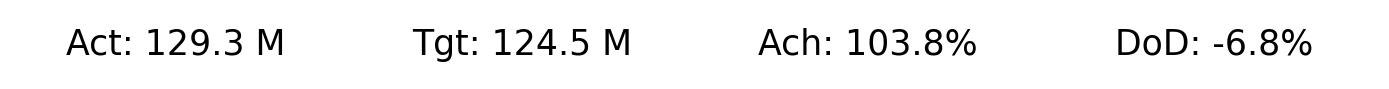

In [144]:
''' Daily Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(y_act.iloc[-1],',.1f')} M", size=25, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(y_tgt.iloc[-1],',.1f')} M", size=25, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(y_achv.iloc[-1],',.1%')}", size=25, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"DoD: {format(y_dod.iloc[-1],',.1%')}", size=25, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

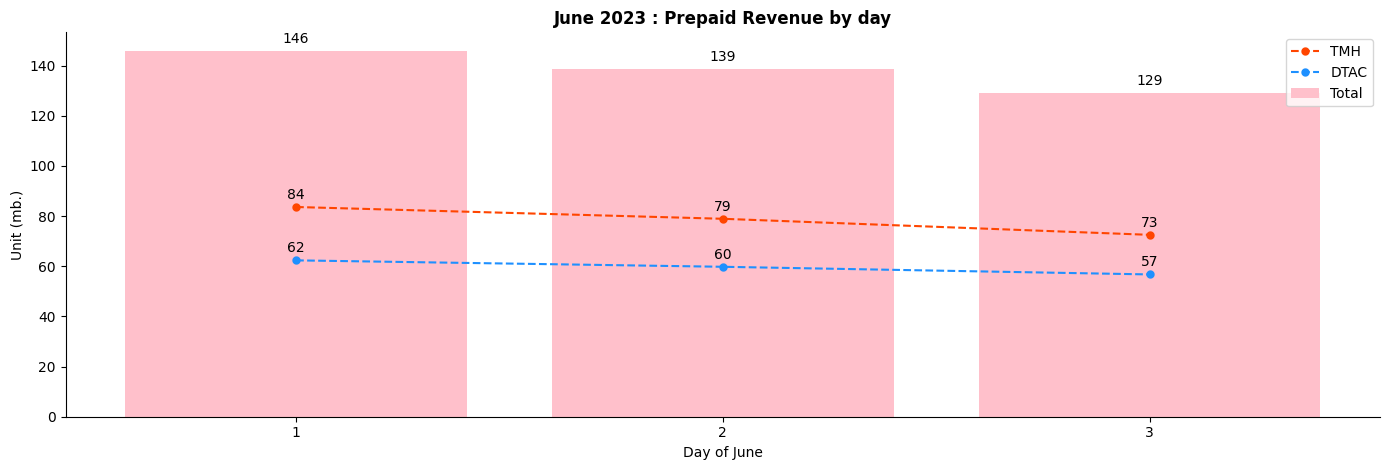

In [145]:
''' Revenue by day '''

plt.figure().set_figwidth(14)

plt.title(f'{curr_mth_desc} {curr_yr} : Prepaid Revenue by day', fontdict={'fontweight': 'bold'})
plt.bar(x_axis, y_act, label='Total', color='pink')
plt.plot(x_axis, y_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='TMH', color='orangered')
plt.plot(x_axis, y_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC', color='dodgerblue')
for i in x_axis:
    plt.annotate(format(y_act[i],',.0f'), xy=(x_axis[i], y_act[i]+2), ha='center', va='bottom')
    plt.annotate(format(y_act_tmh[i],',.0f'), xy=(x_axis[i], y_act_tmh[i]+2), ha='center', va='bottom')
    plt.annotate(format(y_act_dtac[i],',.0f'), xy=(x_axis[i], y_act_dtac[i]+2), ha='center', va='bottom')
    
plt.xlabel(f'Day of {curr_mth_desc}')
plt.ylabel('Unit (mb.)')
plt.xticks(x_axis, x)
plt.legend()
plt.tight_layout()
plt.show()

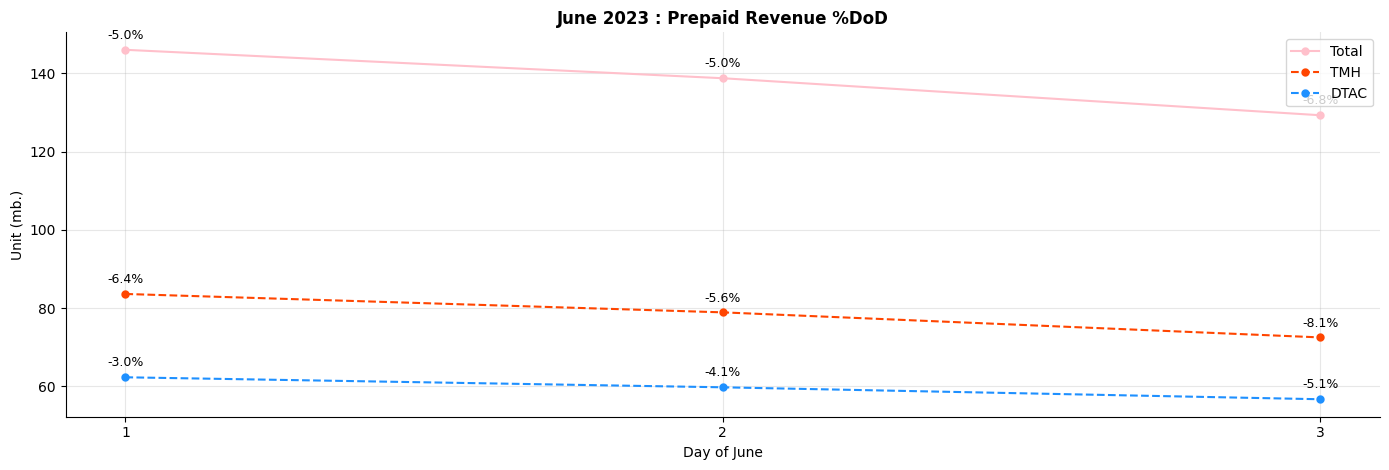

In [146]:
''' Revenue %DoD '''

plt.figure().set_figwidth(14)

plt.title(f'{curr_mth_desc} {curr_yr} : Prepaid Revenue %DoD', fontdict={'fontweight': 'bold'})
plt.plot(x_axis, y_act, marker='.', markeredgewidth=3, label='Total', color='pink')
plt.plot(x_axis, y_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='TMH', color='orangered')
plt.plot(x_axis, y_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC', color='dodgerblue')
for i in x_axis:
    plt.annotate(f"{format(y_dod[i],',.1%')}", xy=(x_axis[i], y_act[i]+2), ha='center', va='bottom', fontsize=9)
    plt.annotate(f"{format(y_dod_tmh[i],',.1%')}", xy=(x_axis[i], y_act_tmh[i]+2), ha='center', va='bottom', fontsize=9)
    plt.annotate(f"{format(y_dod_dtac[i],',.1%')}", xy=(x_axis[i], y_act_dtac[i]+2), ha='center', va='bottom', fontsize=9)
plt.xlabel(f'Day of {curr_mth_desc}')
plt.ylabel('Unit (mb.)')
plt.xticks(x_axis, x)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### DAY : Prepaid Performance : %Achievement & Gap

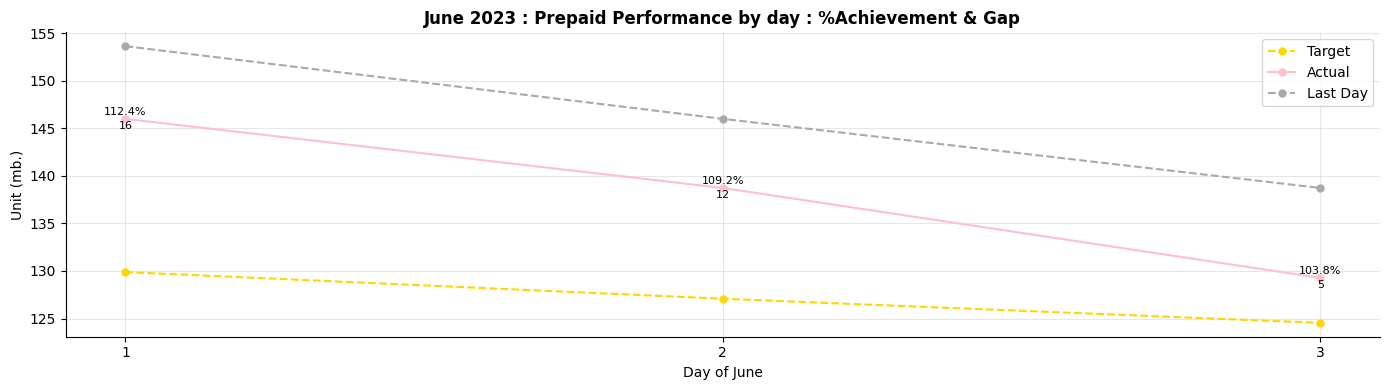

In [147]:
''' Peformance : %Achievement & Gap : Day Chart '''

# plt.figure().set_figwidth(14)
plt.figure(figsize=(14, 4))
plt.title(f"{curr_mth_desc} {curr_yr} : Prepaid Performance by day : %Achievement & Gap", weight='bold')

plt.plot(x_axis, y_tgt, marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
plt.plot(x_axis, y_act, marker='.', markeredgewidth=3, label='Actual', color='pink')
plt.plot(x_axis, y_last_act, marker='.', linestyle='dashed', markeredgewidth=3, label='Last Day', color='darkgray')
for i in x_axis:
    plt.annotate(format(y_achv[i],',.1%'), xy=(x_axis[i], y_act[i]+0.2), ha='center', va='bottom', fontsize=8)
    plt.annotate(format(y_gap[i],',.0f'), xy=(x_axis[i], y_act[i]-0.2), ha='center', va='top', fontsize=8)

plt.xlabel(f'Day of {curr_mth_desc}')
plt.ylabel('Unit (mb.)')
plt.xticks(x_axis, x)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

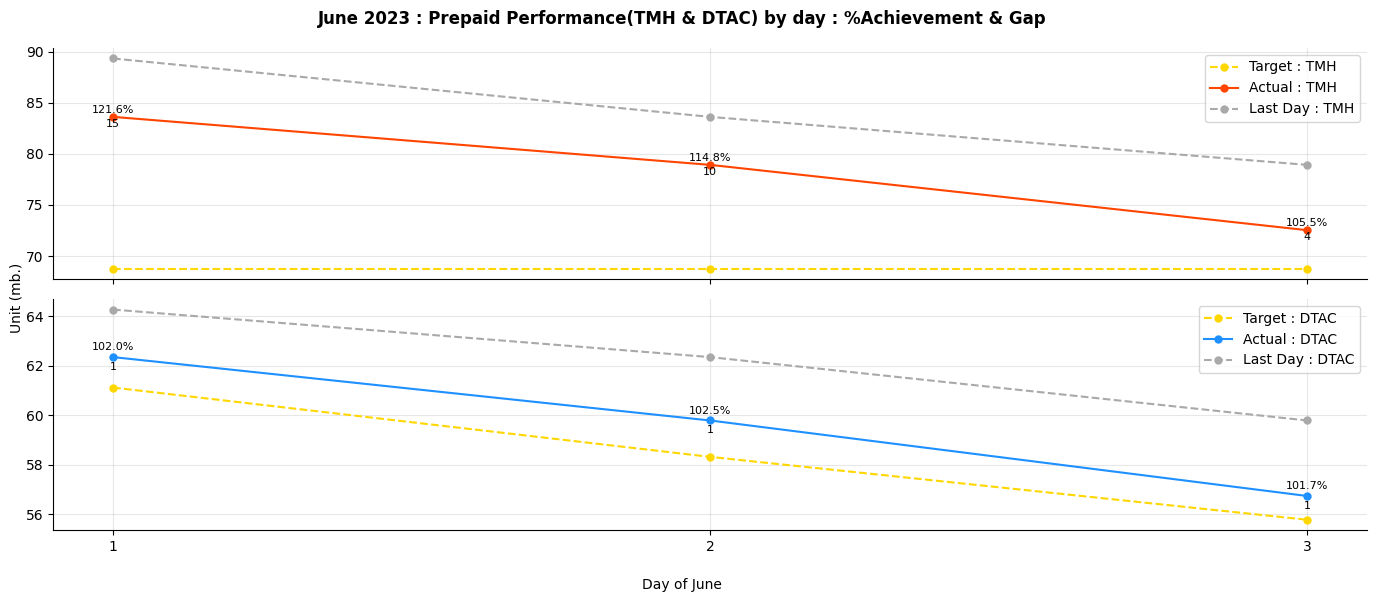

In [148]:
''' Peformance(TMH & DTAC) : %Achievement & Gap : Day Chart '''

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(14, 6))
fig.suptitle(f"{curr_mth_desc} {curr_yr} : Prepaid Performance(TMH & DTAC) by day : %Achievement & Gap", weight='bold')

''' ax1 '''
ax1.plot(x_axis, y_tgt_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Target : TMH', color='gold')
ax1.plot(x_axis, y_act_tmh, marker='.', markeredgewidth=3, label='Actual : TMH', color='orangered')
ax1.plot(x_axis, y_last_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Last Day : TMH', color='darkgray')
ax1.legend()
ax1.grid(alpha=0.3)
for i in x_axis:
    ax1.annotate(format(y_achv_tmh[i],',.1%'), xy=(x_axis[i], y_act_tmh[i]+0.2), ha='center', va='bottom', fontsize=8)
    ax1.annotate(format(y_gap_tmh[i],',.0f'), xy=(x_axis[i], y_act_tmh[i]-0.2), ha='center', va='top', fontsize=8)

''' ax2 '''
ax2.plot(x_axis, y_tgt_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Target : DTAC', color='gold')
ax2.plot(x_axis, y_act_dtac, marker='.', markeredgewidth=3, label='Actual : DTAC', color='dodgerblue')
ax2.plot(x_axis, y_last_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Last Day : DTAC', color='darkgray')
ax2.legend()
ax2.grid(alpha=0.3)
for i in x_axis:
    ax2.annotate(format(y_achv_dtac[i],',.1%'), xy=(x_axis[i], y_act_dtac[i]+0.2), ha='center', va='bottom', fontsize=8)
    ax2.annotate(format(y_gap_dtac[i],',.0f'), xy=(x_axis[i], y_act_dtac[i]-0.2), ha='center', va='top', fontsize=8)

fig.supxlabel(f'Day of {curr_mth_desc}', fontsize=10)
fig.supylabel('Unit (mb.)', fontsize=10)
fig.tight_layout()
plt.xticks(x_axis, x)
plt.show()

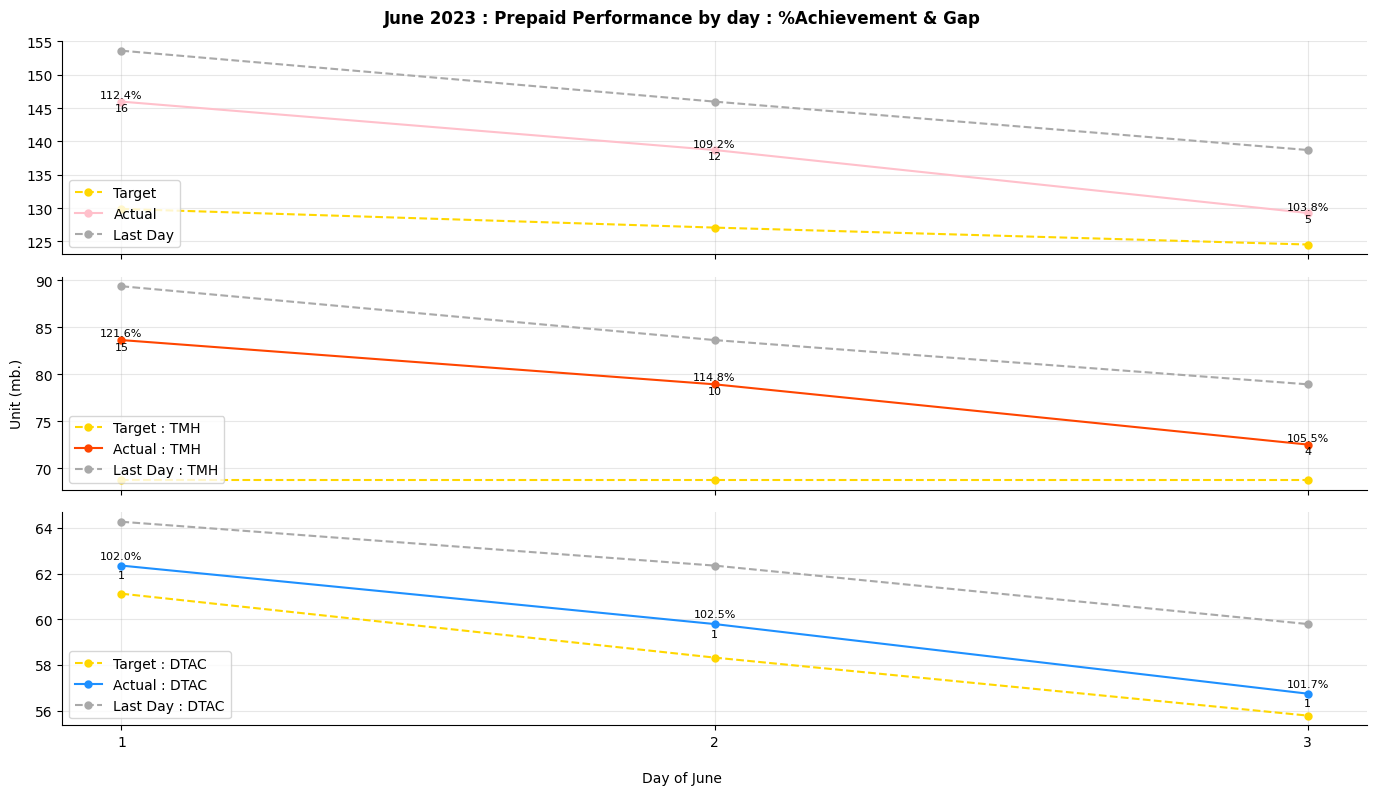

In [149]:
''' Temp : Peformance : %Achievement & Gap : Day Chart '''

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(14, 8))
fig.suptitle(f"{curr_mth_desc} {curr_yr} : Prepaid Performance by day : %Achievement & Gap", weight='bold')

''' ax1 '''
ax1.plot(x_axis, y_tgt, marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
ax1.plot(x_axis, y_act, marker='.', markeredgewidth=3, label='Actual', color='pink')
ax1.plot(x_axis, y_last_act, marker='.', linestyle='dashed', markeredgewidth=3, label='Last Day', color='darkgray')
ax1.legend(loc='lower left')
ax1.grid(alpha=0.3)
for i in x_axis:
    ax1.annotate(format(y_achv[i],',.1%'), xy=(x_axis[i], y_act[i]+0.2), ha='center', va='bottom', fontsize=8)
    ax1.annotate(format(y_gap[i],',.0f'), xy=(x_axis[i], y_act[i]-0.2), ha='center', va='top', fontsize=8)

''' ax2 '''
ax2.plot(x_axis, y_tgt_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Target : TMH', color='gold')
ax2.plot(x_axis, y_act_tmh, marker='.', markeredgewidth=3, label='Actual : TMH', color='orangered')
ax2.plot(x_axis, y_last_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Last Day : TMH', color='darkgray')
ax2.legend(loc='lower left')
ax2.grid(alpha=0.3)
for i in x_axis:
    ax2.annotate(format(y_achv_tmh[i],',.1%'), xy=(x_axis[i], y_act_tmh[i]+0.2), ha='center', va='bottom', fontsize=8)
    ax2.annotate(format(y_gap_tmh[i],',.0f'), xy=(x_axis[i], y_act_tmh[i]-0.2), ha='center', va='top', fontsize=8)

''' ax3 '''
ax3.plot(x_axis, y_tgt_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Target : DTAC', color='gold')
ax3.plot(x_axis, y_act_dtac, marker='.', markeredgewidth=3, label='Actual : DTAC', color='dodgerblue')
ax3.plot(x_axis, y_last_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Last Day : DTAC', color='darkgray')
ax3.legend(loc='lower left')
ax3.grid(alpha=0.3)
for i in x_axis:
    ax3.annotate(format(y_achv_dtac[i],',.1%'), xy=(x_axis[i], y_act_dtac[i]+0.2), ha='center', va='bottom', fontsize=8)
    ax3.annotate(format(y_gap_dtac[i],',.0f'), xy=(x_axis[i], y_act_dtac[i]-0.2), ha='center', va='top', fontsize=8)

fig.supxlabel(f'Day of {curr_mth_desc}', fontsize=10)
fig.supylabel('Unit (mb.)', fontsize=10)
fig.tight_layout()
plt.xticks(x_axis, x)
plt.show()